# Fallstudie Tablet GmbH

# Problemstellung

- Warum war die wirtschaftlich Entwicklung in den letzten beiden Jahren negativ? 
- Welche Faktoren beeinflussten die Situation?
- Wie kann die wirtschaftliche Situation verbessert werden?

# Hypothesen & Fragestellungen (bisher):
- Veränderung der Nachfrage hin zu Tablet Pro & Tablet Mini und weg von Tablet Basic (Silas)
    - Customer Rating als möglicher Indikator (Daniel)
- Downtime als Grund für den geringeren Umsatz in Online-Vertriebskanälen (Vincenzo)
- Sind bestimmte Regionen abhängig von bestimmten Vertriebskanälen/Produkten? (Ali)
- Was verursachte den Umsatzrückgang zum Jahreswechsel? (Ali)

# 0) Allgemeine Einstellungen

In [1]:
# Importieren der benötigten Bibliotheken
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import statsmodels.formula.api as smf

In [2]:
# Zahlen in Dataframes ohne wissenschaftliche Notation ausgeben (zwei Nachkommastellen und Tausendertrennzeichen)
pd.options.display.float_format = '{:,.2f}'.format

# 1) Einlesen

In [3]:
df_crm = pd.read_csv("./data_csv/CRM_data.csv")
df_downtime = pd.read_csv("./data_csv/Downtime.csv")
df_preise = pd.read_csv("./data_csv/Preise.csv")

df_a_online = pd.read_csv("./data_csv/RegionA_online.csv")
df_a_phone = pd.read_csv("./data_csv/RegionA_phone.csv")
df_a_store = pd.read_csv("./data_csv/RegionA_store.csv")

df_b_online = pd.read_csv("./data_csv/RegionB_online.csv")
df_b_phone = pd.read_csv("./data_csv/RegionB_phone.csv")
df_b_store = pd.read_csv("./data_csv/RegionB_store.csv")

df_c_online = pd.read_csv("./data_csv/RegionC_online.csv")
df_c_phone = pd.read_csv("./data_csv/RegionC_phone.csv")
df_c_store = pd.read_csv("./data_csv/RegionC_store.csv")

df_d_online = pd.read_csv("./data_csv/RegionD_online.csv")
df_d_phone = pd.read_csv("./data_csv/RegionD_phone.csv")
df_d_store = pd.read_csv("./data_csv/RegionD_store.csv")

# 2) Aufbereiten

## CRM-Daten:

In [4]:
df_crm.head()

,id,vorname,nachname,iban,email,customer_rating
0,0,Curt,Roskoth,DE29557982464763273025,curt.roskoth@gmx.de,7.20
1,1,Till,Klingelhöfer,DE36890407044640624074,till.klingelhöfer@gmail.com,8.40
2,2,Dora,Winkler,DE26144834913572865717,dora.winkler@web.de,6.70
3,3,Tom,Krause,DE16352804742225738584,tom.krause@aol.de,9.40
4,4,Dina,Matthäi,DE24968455090529372560,dina.matthäi@hotmail.de,9.10


In [5]:
df_crm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340000 entries, 0 to 339999
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               340000 non-null  int64  
 1   vorname          340000 non-null  object 
 2   nachname         340000 non-null  object 
 3   iban             340000 non-null  object 
 4   email            340000 non-null  object 
 5   customer_rating  340000 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 15.6+ MB


In [6]:
# Spalten auf Englisch umbenennen
df_crm = df_crm.rename(columns={
    'vorname': 'first_name',
    'nachname': 'last_name',
})

df_crm.head()

,id,first_name,last_name,iban,email,customer_rating
0,0,Curt,Roskoth,DE29557982464763273025,curt.roskoth@gmx.de,7.20
1,1,Till,Klingelhöfer,DE36890407044640624074,till.klingelhöfer@gmail.com,8.40
2,2,Dora,Winkler,DE26144834913572865717,dora.winkler@web.de,6.70
3,3,Tom,Krause,DE16352804742225738584,tom.krause@aol.de,9.40
4,4,Dina,Matthäi,DE24968455090529372560,dina.matthäi@hotmail.de,9.10


## Preisdaten:

In [7]:
df_preise

,Jahr,product,preis
0,"""2021""",Tablet Pro,999
1,"""""20022""",Tablet Pro,999
2,"""2021""",Tablet Mini,680
3,"""""20022""",Tablet Mini,550
4,"""2021""",Tablet Basics,529
5,"""""20022""",Tablet Basics,499


In [8]:
# Umbenennen der Spalte "Jahr" in "year"
df_preise = df_preise.rename(columns={"Jahr": "year",
                                      "preis": "price"})

# Entfernen von Anfuehrungszeichen
df_preise['year'] = df_preise['year'].apply(lambda x: x.strip('"')) 

# Korrigieren der falschen Jahreszahlen
df_preise['year'] = df_preise['year'].replace({'20022': '2022'})  

# Umwandeln der Spalte "jahr" in Datumsformat
df_preise['year'] = pd.to_datetime(df_preise['year'], format='%Y')

# Spalte "jahr" als Jahreszahl extrahieren
df_preise['year'] = df_preise['year'].dt.year

# Werte "Tablet Basics" in "Tablet Basic" ändern
df_preise['product'] = df_preise['product'].replace({'Tablet Basics': 'Tablet Basic'})

df_preise

,year,product,price
0,2021,Tablet Pro,999
1,2022,Tablet Pro,999
2,2021,Tablet Mini,680
3,2022,Tablet Mini,550
4,2021,Tablet Basic,529
5,2022,Tablet Basic,499


## Downtime-Daten:

In [9]:
df_downtime

,Unnamed: 0,Region A,Region B,Region C,Region D
0,2021,0.10,0.01,0.05,0.00
1,2022,0.15,0.15,0.04,0.01


In [10]:
# Erste Spalte in "year" umbenennen
df_downtime = df_downtime.rename(columns={"Unnamed: 0": "year"})

# Spalte "year" in Datumsformat umwandeln
df_downtime['year'] = pd.to_datetime(df_downtime['year'], format='%Y')

# Spalte "year" als Jahreszahl extrahieren
df_downtime['year'] = df_downtime['year'].dt.year

# Umbenennen der Spalten "Region A" bis "Region D" in "region_a" bis "region_d"
df_downtime = df_downtime.rename(columns={"Region A": "region_a", 
                                          "Region B": "region_b", 
                                          "Region C": "region_c", 
                                          "Region D": "region_d"})

df_downtime

,year,region_a,region_b,region_c,region_d
0,2021,0.10,0.01,0.05,0.00
1,2022,0.15,0.15,0.04,0.01


In [11]:
# df_downtime umformen: Spalten sind die beiden Jahre und die Zeilen die Regionen
df_downtime = df_downtime.melt(id_vars=['year'], var_name='region', value_name='downtime')

# Werte in der Spalte "region" in "A" bis "D" umbenennen
df_downtime['region'] = df_downtime['region'].replace({'region_a': 'A', 
                                                       'region_b': 'B', 
                                                       'region_c': 'C', 
                                                       'region_d': 'D'})

df_downtime

,year,region,downtime
0,2021,A,0.10
1,2022,A,0.15
2,2021,B,0.01
3,2022,B,0.15
4,2021,C,0.05
5,2022,C,0.04
6,2021,D,0.00
7,2022,D,0.01


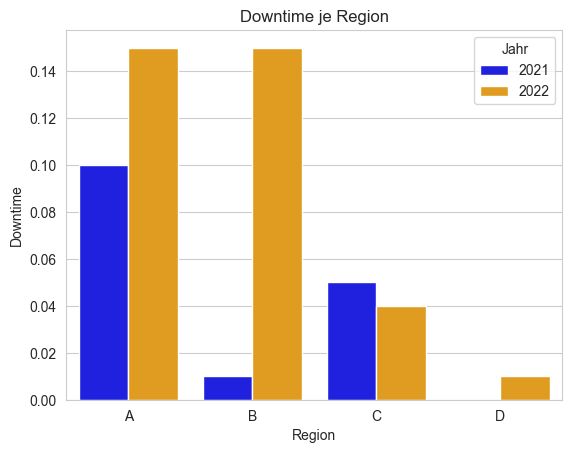

In [12]:
# df_downtime als Säulendiagramm darstellen
sns.set_style("whitegrid")

# Farbpalette definieren (Blau für 2021, Orange für 2022)
colors = ["blue", "orange"]

# Säulendiagramm erstellen
ax = sns.barplot(x="region", y="downtime", hue="year", data=df_downtime, palette=colors)

# Achsenbeschriftung
ax.set_xlabel("Region")
ax.set_ylabel("Downtime")

# Legende
ax.legend(title="Jahr", loc="upper right")

# Titel
ax.set_title("Downtime je Region")

# Diagramm anzeigen
plt.show()

## Transaktionsdaten:

In [13]:
# Hinzufuegen der Spalten "region" und "channel" mit den entsprechenden Werten
df_a_online = df_a_online.assign(region='A', channel='online')
df_a_phone = df_a_phone.assign(region='A', channel='phone')
df_a_store = df_a_store.assign(region='A', channel='store')

df_b_online = df_b_online.assign(region='B', channel='online')
df_b_phone = df_b_phone.assign(region='B', channel='phone')
df_b_store = df_b_store.assign(region='B', channel='store')

df_c_online = df_c_online.assign(region='C', channel='online')
df_c_phone = df_c_phone.assign(region='C', channel='phone')
df_c_store = df_c_store.assign(region='C', channel='store')

df_d_online = df_d_online.assign(region='D', channel='online')
df_d_phone = df_d_phone.assign(region='D', channel='phone')
df_d_store = df_d_store.assign(region='D', channel='store')

In [14]:
# Umbenennen der Spalte "PRODUKT" in "product" in df_b_phone
df_b_phone = df_b_phone.rename(columns={"PRODUKT": "product"})

In [15]:
# Alle Regionen in einen Dataframe zusammenfassen
df_sales = pd.concat([df_a_online, df_a_phone, df_a_store,
                      df_b_online, df_b_phone, df_b_store, 
                      df_c_online, df_c_phone, df_c_store, 
                      df_d_online, df_d_phone, df_d_store])

In [16]:
# Umbenennen der Spalten "Tablet Basic", "Tablet Mini" und "Tablet Pro", "kosten_basic", "kosten_mini" und "kosten_pro"
df_sales = df_sales.rename(columns={
    "Tablet Basic": "tablet_basic",
    "Tablet Mini": "tablet_mini",
    "Tablet Pro": "tablet_pro",
    "kosten_basic": "cost_basic",
    "kosten_mini": "cost_mini",
    "kosten_pro": "cost_pro"
})

In [17]:
# Umwandeln der Spalte "jahr" in Datumsformat
df_sales["date"] = pd.to_datetime(df_sales["date"])

In [18]:
# NaN in den Spalten cost_basic, cost_mini und cost_pro durch 0 ersetzen
df_sales['cost_basic'] = df_sales['cost_basic'].fillna(0)
df_sales['cost_mini'] = df_sales['cost_mini'].fillna(0)
df_sales['cost_pro'] = df_sales['cost_pro'].fillna(0)

In [19]:
# NaN in "discount" durch 1 ersetzen
df_sales['discount'] = df_sales['discount'].fillna(1)

# Discount tatsächlichen Wert berechnen
df_sales['discount'] = 1 - df_sales['discount']

In [20]:
# Zeige Werte der Spalte "product" an
df_sales['product'].unique()

array(['Tablet Basic', 'Tablet Mini', 'Tablet Pro', 'Tablet Basic...'],
      dtype=object)

In [21]:
# Werte "Tablet Basic..." in "Tablet Basic" aendern
df_sales['product'] = df_sales['product'].replace({'Tablet Basic...': 'Tablet Basic'})

In [22]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 340000 entries, 0 to 49438
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            340000 non-null  datetime64[ns]
 1   product         340000 non-null  object        
 2   discount        340000 non-null  float64       
 3   amount          340000 non-null  int64         
 4   tablet_basic    340000 non-null  int64         
 5   tablet_mini     340000 non-null  int64         
 6   tablet_pro      340000 non-null  int64         
 7   cost_basic      340000 non-null  float64       
 8   cost_mini       340000 non-null  float64       
 9   cost_pro        340000 non-null  float64       
 10  transaction_id  340000 non-null  int64         
 11  region          340000 non-null  object        
 12  channel         340000 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(5), object(3)
memory usage: 36.3+ MB


In [23]:
df_sales

,date,product,discount,amount,tablet_basic,tablet_mini,tablet_pro,cost_basic,cost_mini,cost_pro,transaction_id,region,channel
0,2021-11-01,Tablet Basic,0.00,5,1,0,0,170.02,0.00,0.00,22,A,online
1,2021-11-01,Tablet Basic,0.00,7,1,0,0,170.02,0.00,0.00,24,A,online
2,2021-11-01,Tablet Basic,0.10,7,1,0,0,210.03,0.00,0.00,40,A,online
3,2021-11-01,Tablet Basic,0.00,10,1,0,0,170.08,0.00,0.00,95,A,online
4,2021-11-01,Tablet Basic,0.00,4,1,0,0,170.09,0.00,0.00,104,A,online
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49434,2022-10-31,Tablet Pro,0.00,3,0,0,1,0.00,0.00,984.99,339978,D,store
49435,2022-10-31,Tablet Pro,0.00,1,0,0,1,0.00,0.00,984.99,339981,D,store
49436,2022-10-31,Tablet Pro,0.00,3,0,0,1,0.00,0.00,984.99,339986,D,store
49437,2022-10-31,Tablet Pro,0.00,2,0,0,1,0.00,0.00,985.00,339991,D,store


# 3) Transformieren

In [24]:
# df_sales und df_crm zusammenfuegen
df_sales = pd.merge(df_sales, df_crm, left_on='transaction_id', right_on='id', how='inner')

# Spalte "id" entfernen
df_sales = df_sales.drop(columns=['id'])

# Neue Spalten "year", "month" und "week" erstellen
df_sales = df_sales.assign(year=df_sales['date'].dt.year,
                           month=df_sales['date'].dt.month,
                           week=df_sales['date'].dt.isocalendar().week)

# Neue Spalte "price" erstellen, basierend auf den Werten in der Spalte "price" in df_preise
df_sales = df_sales.merge(df_preise, on=["year", "product"], how="left")

# Neue Spalte "cost" erstellen
df_sales['cost'] = df_sales["cost_basic"] + df_sales["cost_mini"] + df_sales["cost_pro"]

# Neue Spalte "cost_total" erstellen
df_sales['cost_total'] = df_sales["cost"] * df_sales["amount"]

# Neue Spalte "revenue" erstellen
df_sales['revenue'] = df_sales['price'] * df_sales['amount'] * (1 - df_sales['discount'])

# Neue Spalte "profit_per_piece" erstellen
df_sales["profit_per_piece"] = (df_sales["price"] * (1 - df_sales["discount"])) - df_sales["cost"]

# Neue Spalte "profit_total" erstellen
df_sales["profit_total"] = df_sales["profit_per_piece"] * df_sales["amount"]

# Alle Spalten anzeigen lassen
pd.set_option('display.max_columns', None)
df_sales

,date,product,discount,amount,tablet_basic,tablet_mini,tablet_pro,cost_basic,cost_mini,cost_pro,transaction_id,region,channel,first_name,last_name,iban,email,customer_rating,year,month,week,price,cost,cost_total,revenue,profit_per_piece,profit_total
0,2021-11-01,Tablet Basic,0.00,5,1,0,0,170.02,0.00,0.00,22,A,online,Friedhilde,Kuhl,DE23093007879691629842,friedhilde.kuhl@yahoo.de,7.10,2021,11,44,529,170.02,850.09,"2,645.00",358.98,"1,794.91"
1,2021-11-01,Tablet Basic,0.00,7,1,0,0,170.02,0.00,0.00,24,A,online,Heide-Marie,Fischer,DE26303459399974289421,heide-marie.fischer@gmx.de,5.90,2021,11,44,529,170.02,"1,190.14","3,703.00",358.98,"2,512.86"
2,2021-11-01,Tablet Basic,0.10,7,1,0,0,210.03,0.00,0.00,40,A,online,Ester,Pruschke,DE04679916372817044326,ester.pruschke@gmail.com,7.50,2021,11,44,529,210.03,"1,470.23","3,332.70",266.07,"1,862.47"
3,2021-11-01,Tablet Basic,0.00,10,1,0,0,170.08,0.00,0.00,95,A,online,Klaus,Blümel,DE54334149840465696270,klaus.blümel@aol.de,6.60,2021,11,44,529,170.08,"1,700.78","5,290.00",358.92,"3,589.22"
4,2021-11-01,Tablet Basic,0.00,4,1,0,0,170.09,0.00,0.00,104,A,online,Waldemar,Fritsch,DE54862551075047386387,waldemar.fritsch@web.de,7.30,2021,11,44,529,170.09,680.34,"2,116.00",358.91,"1,435.66"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339995,2022-10-31,Tablet Pro,0.00,3,0,0,1,0.00,0.00,984.99,339978,D,store,Carla,Klemm,DE95736837564420121887,carla.klemm@web.de,7.60,2022,10,44,999,984.99,"2,954.96","2,997.00",14.01,42.04
339996,2022-10-31,Tablet Pro,0.00,1,0,0,1,0.00,0.00,984.99,339981,D,store,Hans-Uwe,Döring,DE96536545575195298222,hans-uwe.döring@yahoo.de,7.60,2022,10,44,999,984.99,984.99,999.00,14.01,14.01
339997,2022-10-31,Tablet Pro,0.00,3,0,0,1,0.00,0.00,984.99,339986,D,store,Irene,Aumann,DE83463083316300535191,irene.aumann@hotmail.de,8.30,2022,10,44,999,984.99,"2,954.98","2,997.00",14.01,42.02
339998,2022-10-31,Tablet Pro,0.00,2,0,0,1,0.00,0.00,985.00,339991,D,store,Jolanthe,Spieß,DE73981381785498034616,jolanthe.spieß@gmx.de,9.20,2022,10,44,999,985.00,"1,969.99","1,998.00",14.00,28.01


In [25]:
# Drop columns "first_name" and "last_name", "iban", "email"
df_sales = df_sales.drop(columns=['first_name', 'last_name', 'iban', 'email'])
df_sales

,date,product,discount,amount,tablet_basic,tablet_mini,tablet_pro,cost_basic,cost_mini,cost_pro,transaction_id,region,channel,customer_rating,year,month,week,price,cost,cost_total,revenue,profit_per_piece,profit_total
0,2021-11-01,Tablet Basic,0.00,5,1,0,0,170.02,0.00,0.00,22,A,online,7.10,2021,11,44,529,170.02,850.09,"2,645.00",358.98,"1,794.91"
1,2021-11-01,Tablet Basic,0.00,7,1,0,0,170.02,0.00,0.00,24,A,online,5.90,2021,11,44,529,170.02,"1,190.14","3,703.00",358.98,"2,512.86"
2,2021-11-01,Tablet Basic,0.10,7,1,0,0,210.03,0.00,0.00,40,A,online,7.50,2021,11,44,529,210.03,"1,470.23","3,332.70",266.07,"1,862.47"
3,2021-11-01,Tablet Basic,0.00,10,1,0,0,170.08,0.00,0.00,95,A,online,6.60,2021,11,44,529,170.08,"1,700.78","5,290.00",358.92,"3,589.22"
4,2021-11-01,Tablet Basic,0.00,4,1,0,0,170.09,0.00,0.00,104,A,online,7.30,2021,11,44,529,170.09,680.34,"2,116.00",358.91,"1,435.66"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339995,2022-10-31,Tablet Pro,0.00,3,0,0,1,0.00,0.00,984.99,339978,D,store,7.60,2022,10,44,999,984.99,"2,954.96","2,997.00",14.01,42.04
339996,2022-10-31,Tablet Pro,0.00,1,0,0,1,0.00,0.00,984.99,339981,D,store,7.60,2022,10,44,999,984.99,984.99,999.00,14.01,14.01
339997,2022-10-31,Tablet Pro,0.00,3,0,0,1,0.00,0.00,984.99,339986,D,store,8.30,2022,10,44,999,984.99,"2,954.98","2,997.00",14.01,42.02
339998,2022-10-31,Tablet Pro,0.00,2,0,0,1,0.00,0.00,985.00,339991,D,store,9.20,2022,10,44,999,985.00,"1,969.99","1,998.00",14.00,28.01


In [26]:
# Sortieren nach Datum
df_sales.sort_values(by=['transaction_id'], inplace=True)

# Reset der Index-Spalte
df_sales.reset_index(drop=True, inplace=True)

In [27]:
df_sales

,date,product,discount,amount,tablet_basic,tablet_mini,tablet_pro,cost_basic,cost_mini,cost_pro,transaction_id,region,channel,customer_rating,year,month,week,price,cost,cost_total,revenue,profit_per_piece,profit_total
0,2021-11-01,Tablet Pro,0.00,4,0,0,1,0.00,0.00,695.00,0,C,store,7.20,2021,11,44,999,695.00,"2,780.00","3,996.00",304.00,"1,216.00"
1,2021-11-01,Tablet Basic,0.00,3,1,0,0,170.00,0.00,0.00,1,D,online,8.40,2021,11,44,529,170.00,510.00,"1,587.00",359.00,"1,077.00"
2,2021-11-01,Tablet Basic,0.10,5,1,0,0,200.00,0.00,0.00,2,C,phone,6.70,2021,11,44,529,200.00,"1,000.01","2,380.50",276.10,"1,380.49"
3,2021-11-01,Tablet Basic,0.00,2,1,0,0,170.00,0.00,0.00,3,B,online,9.40,2021,11,44,529,170.00,340.00,"1,058.00",359.00,718.00
4,2021-11-01,Tablet Basic,0.00,2,1,0,0,150.00,0.00,0.00,4,C,online,9.10,2021,11,44,529,150.00,300.01,"1,058.00",379.00,757.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339995,2022-10-31,Tablet Pro,0.00,2,0,0,1,0.00,0.00,865.00,339995,D,phone,8.40,2022,10,44,999,865.00,"1,730.00","1,998.00",134.00,268.00
339996,2022-10-31,Tablet Pro,0.00,3,0,0,1,0.00,0.00,865.00,339996,D,phone,8.20,2022,10,44,999,865.00,"2,594.99","2,997.00",134.00,402.01
339997,2022-10-31,Tablet Pro,0.00,2,0,0,1,0.00,0.00,945.00,339997,D,store,9.90,2022,10,44,999,945.00,"1,890.00","1,998.00",54.00,108.00
339998,2022-10-31,Tablet Pro,0.00,4,0,0,1,0.00,0.00,865.00,339998,B,store,8.70,2022,10,44,999,865.00,"3,460.00","3,996.00",134.00,536.00


In [28]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340000 entries, 0 to 339999
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              340000 non-null  datetime64[ns]
 1   product           340000 non-null  object        
 2   discount          340000 non-null  float64       
 3   amount            340000 non-null  int64         
 4   tablet_basic      340000 non-null  int64         
 5   tablet_mini       340000 non-null  int64         
 6   tablet_pro        340000 non-null  int64         
 7   cost_basic        340000 non-null  float64       
 8   cost_mini         340000 non-null  float64       
 9   cost_pro          340000 non-null  float64       
 10  transaction_id    340000 non-null  int64         
 11  region            340000 non-null  object        
 12  channel           340000 non-null  object        
 13  customer_rating   340000 non-null  float64       
 14  year

In [29]:
# summe der kosten nach produkt
df_sales.groupby(['product'])['cost_total'].sum()

product
Tablet Basic    66,372,966.49
Tablet Mini     58,453,967.68
Tablet Pro     268,538,743.05
Name: cost_total, dtype: float64

# Allgemeine Grafiken:

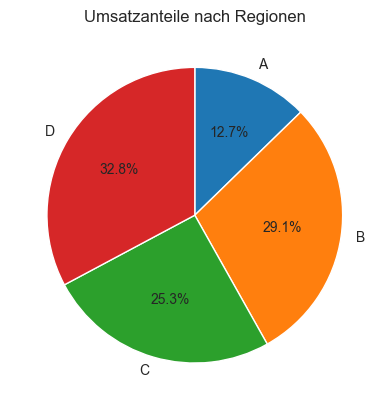

In [30]:
# Anteil am Umsatz nach Region als Kreisdiagramm
df_sales_per_region = df_sales.groupby(['region'])['revenue'].sum()

# Kreisdiagramm
plt.pie(df_sales_per_region, labels=df_sales_per_region.index, autopct='%1.1f%%', counterclock=False, startangle=90)
plt.title('Umsatzanteile nach Regionen')
plt.show()

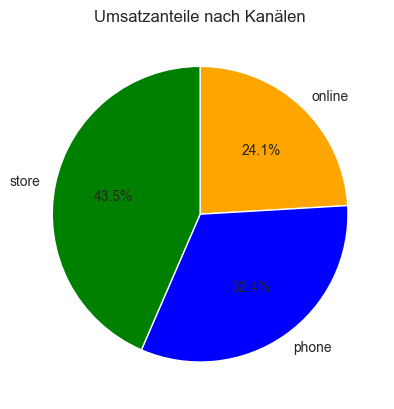

In [31]:
# Anteil am Umsatz nach Kanal als Kreisdiagramm
df_sales_per_channel = df_sales.groupby(['channel'])['revenue'].sum()

colors = ['orange', 'blue', 'green']
# Kreisdiagramm
plt.pie(df_sales_per_channel, labels=df_sales_per_channel.index, autopct='%1.1f%%', counterclock=False, startangle=90, colors=colors)
plt.title('Umsatzanteile nach Kanälen')

# farben definieren (online = orange, phone = blau, store = gruen)


plt.show()

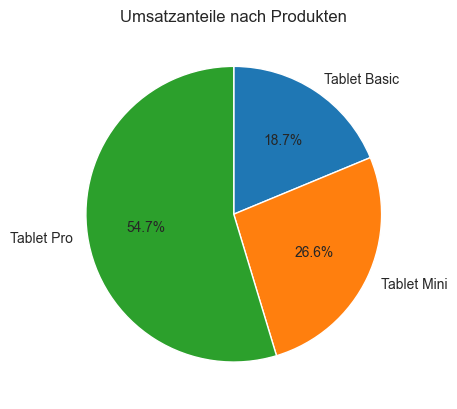

In [32]:
# Anteil am Umsatz nach Produkt als Kreisdiagramm
df_sales_per_product = df_sales.groupby(['product'])['revenue'].sum()

# Kreisdiagramm
plt.pie(df_sales_per_product, labels=df_sales_per_product.index, autopct='%1.1f%%', counterclock=False, startangle=90)
plt.title('Umsatzanteile nach Produkten')
plt.show()

# 4) Analyse der allgemeinen wirtschaftlichen Entwicklung

## Entwicklung der Kennzahlen Verkaufsmenge, Umsatz, Kosten, Gewinn und Umsatzrendite

In [33]:
# df_sales nach Jahr und Monat gruppieren und die Summe der Spalten der Verkaufsmenge, des Umsatzes, der Kosten und des Profits berechnen
df_development = df_sales.groupby(['year', 'month']).agg({"amount" : "sum",
                                                          "revenue" : "sum",
                                                          "cost_total" : "sum",
                                                          "profit_total" : "sum"})

# Berechnung der Umsatzrendite
df_development['profit_margin'] = df_development['profit_total'] / df_development['revenue'] * 100

# Reset der Index-Spalte, um die Spalten "year" und "month" zu erhalten
df_development.reset_index(inplace=True)

df_development

,year,month,amount,revenue,cost_total,profit_total,profit_margin
0,2021,11,61277,"37,858,455.40","16,974,516.77","20,883,938.63",55.16
1,2021,12,65326,"41,972,763.70","20,653,054.65","21,319,709.05",50.79
2,2022,1,64617,"39,768,532.90","23,106,856.89","16,661,676.01",41.90
3,2022,2,61855,"39,256,396.10","23,875,462.54","15,380,933.56",39.18
4,2022,3,68756,"45,568,506.50","29,208,698.42","16,359,808.08",35.90
5,2022,4,65883,"45,260,948.30","30,260,821.29","15,000,127.01",33.14
6,2022,5,70301,"49,696,519.90","34,384,042.72","15,312,477.18",30.81
7,2022,6,69096,"51,100,213.70","36,803,028.94","14,297,184.76",27.98
8,2022,7,70883,"53,743,276.10","39,839,441.12","13,903,834.98",25.87
9,2022,8,73857,"57,443,737.60","43,706,180.05","13,737,557.55",23.91


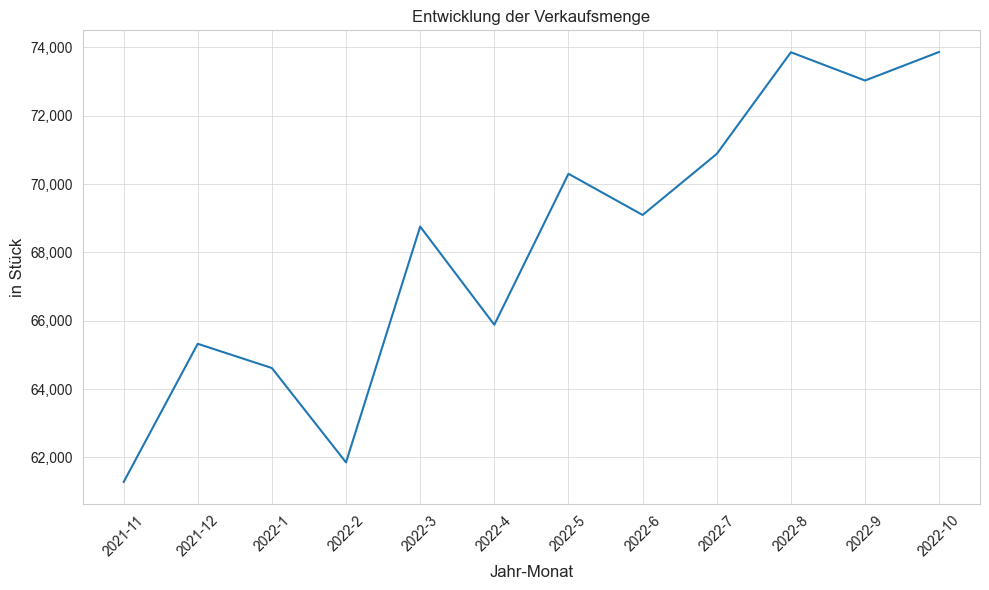

In [34]:
# Visualisierung der Entwicklung der Verkaufsmenge
fig, ax = plt.subplots(figsize=(10, 6))

# Daten plotten
ax.plot(df_development['year'].astype(str) + '-' + df_development['month'].astype(str), df_development['amount'])

# Grid hinzufuegen
ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)
ax.set_ylabel('in Stück', fontsize=12)
ax.set_title('Entwicklung der Verkaufsmenge')

# Tausendertrennzeichen hinzufuegen
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

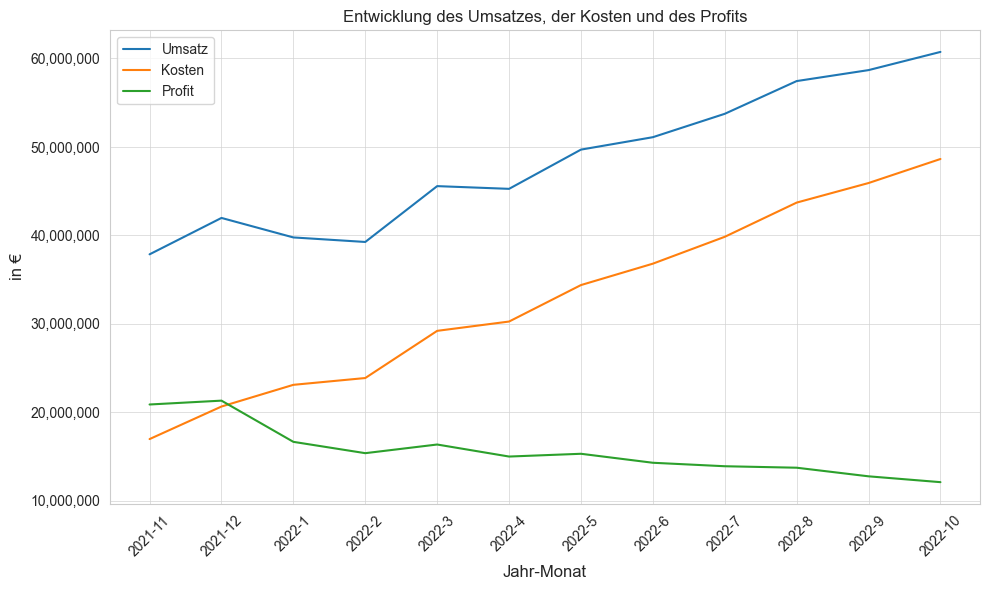

In [35]:
# Visualisierung der Entwicklung des Umsatzes, der Kosten und des Profits
fig, ax = plt.subplots(figsize=(10, 6))

# Daten plotten
ax.plot(df_development['year'].astype(str) + '-' + df_development['month'].astype(str), df_development['revenue'])
ax.plot(df_development['year'].astype(str) + '-' + df_development['month'].astype(str), df_development['cost_total'])
ax.plot(df_development['year'].astype(str) + '-' + df_development['month'].astype(str), df_development['profit_total'])

# Grid hinzufuegen
ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)
ax.set_ylabel('in €', fontsize=12)
ax.set_title('Entwicklung des Umsatzes, der Kosten und des Profits')

# Tausendertrennzeichen hinzufuegen
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Legende hinzufuegen
ax.legend(['Umsatz', 'Kosten', 'Profit'])

# Diagramm anzeigen
plt.tight_layout()
plt.show()

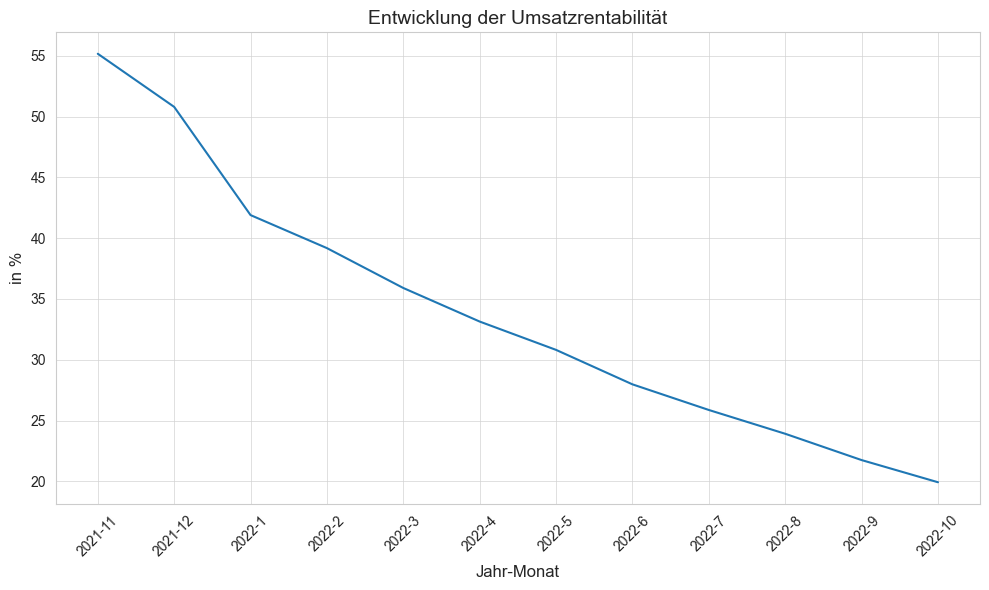

In [36]:
# Visualisierung der Entwicklung der Umsatzrendite
fig, ax = plt.subplots(figsize=(10, 6))

# Daten plotten
ax.plot(df_development['year'].astype(str) + '-' + df_development['month'].astype(str), df_development['profit_margin'])

# Grid hinzufuegen
ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)
ax.set_ylabel('in %', fontsize=12)
ax.set_title('Entwicklung der Umsatzrentabilität', fontsize=14)

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

## Prozentuelle Veränderung von Oktober 2021 bis November 2022

In [37]:
# Veränderung vom Anfang bis zum Ende des Zeitraums in Prozent berechnen 

# Neues Dataframe mit erstellen (KPI, Change in %)
df_kpi = pd.DataFrame(columns=['kpi', 'change_in_percent'])

# Liste mit den KPIs erstellen
kpi = ['amount', 'revenue', 'cost_total', 'profit_total', 'profit_margin']

# Berechnung der Veränderung in Prozent
for i in kpi:
    change = (df_development[i].iloc[-1] / df_development[i].iloc[0] - 1) * 100
    df_kpi.loc[len(df_kpi)] = [i, change]

df_kpi

,kpi,change_in_percent
0,amount,20.55
1,revenue,60.44
2,cost_total,186.52
3,profit_total,-42.04
4,profit_margin,-63.87


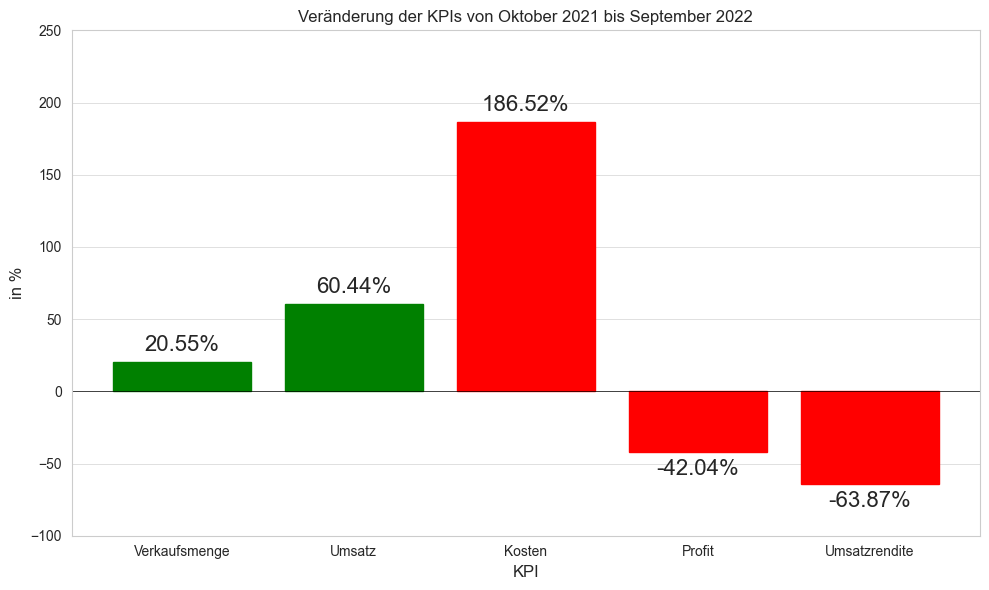

In [38]:
# Visualisierung der Veränderung der KPIs als Säulendiagramm
fig, ax = plt.subplots(figsize=(10, 6))

# Daten plotten
bars = ax.bar(df_kpi['kpi'], df_kpi['change_in_percent'])

# Achsenbeschriftung und Titel hinzufuegen
ax.set_title('Veränderung der KPIs von Oktober 2021 bis September 2022')
ax.set_xlabel('KPI', fontsize=12)
ax.set_ylabel('in %', fontsize=12)

# Nur horizontales Grid hinzufuegen
ax.yaxis.grid(color='lightgrey', linestyle='-', linewidth=0.5)
ax.xaxis.grid(False)

# Linie bei 0 hinzufuegen
ax.axhline(0, color='black', linewidth=0.5)

# Farbe der Säulen anpassen
ax.patches[0].set_color('green')
ax.patches[1].set_color('green')
ax.patches[2].set_color('red')
ax.patches[3].set_color('red')
ax.patches[4].set_color('red')

# Beschriftung der Säulen hinzufuegen
ax.bar_label(bars, fmt='%.2f%%', padding=5, fontsize=16)

# y-Achse Maximum auf 200% und Minimum auf -100% setzen
ax.set_ylim(ymax=250)
ax.set_ylim(ymin=-100)

# X-Achsenbeschriftung auf Deutsch ("Verkaufsmenge", "Umsatz", "Kosten", "Profit", "Umsatzrendite")
ax.xaxis.set_ticks(np.arange(5))
ax.set_xticklabels(['Verkaufsmenge', 'Umsatz', 'Kosten', 'Profit', 'Umsatzrendite'])

# Diagramm anzeigen
plt.tight_layout()
plt.show()

**Erkenntnisse:**
- Verkaufsmenge und Umsatz sind zwar gestiegen, jedoch sind die Kosten explodiert
- Hierdurch ist der Profit um über 40 % gesunken und die Umsatzrendite um über 60 % oder ca. 35 Prozentpunkte

## Stückbetrachtung

In [39]:
# df_development kopieren
df_development_per_piece = df_development.copy()

# Berechnung des Umsatzes pro Stück
df_development_per_piece['revenue_per_piece'] = df_development_per_piece['revenue'] / df_development_per_piece['amount']    

# Berechnung der Kosten pro Stück
df_development_per_piece['cost_per_piece'] = df_development_per_piece['cost_total'] / df_development_per_piece['amount']

# Berechnung des Profits pro Stück
df_development_per_piece['profit_per_piece'] = df_development_per_piece['profit_total'] / df_development_per_piece['amount']

df_development_per_piece

,year,month,amount,revenue,cost_total,profit_total,profit_margin,revenue_per_piece,cost_per_piece,profit_per_piece
0,2021,11,61277,"37,858,455.40","16,974,516.77","20,883,938.63",55.16,617.82,277.01,340.81
1,2021,12,65326,"41,972,763.70","20,653,054.65","21,319,709.05",50.79,642.51,316.15,326.36
2,2022,1,64617,"39,768,532.90","23,106,856.89","16,661,676.01",41.90,615.45,357.60,257.85
3,2022,2,61855,"39,256,396.10","23,875,462.54","15,380,933.56",39.18,634.65,385.99,248.66
4,2022,3,68756,"45,568,506.50","29,208,698.42","16,359,808.08",35.90,662.76,424.82,237.94
5,2022,4,65883,"45,260,948.30","30,260,821.29","15,000,127.01",33.14,686.99,459.31,227.68
6,2022,5,70301,"49,696,519.90","34,384,042.72","15,312,477.18",30.81,706.91,489.10,217.81
7,2022,6,69096,"51,100,213.70","36,803,028.94","14,297,184.76",27.98,739.55,532.64,206.92
8,2022,7,70883,"53,743,276.10","39,839,441.12","13,903,834.98",25.87,758.20,562.05,196.15
9,2022,8,73857,"57,443,737.60","43,706,180.05","13,737,557.55",23.91,777.77,591.77,186.00


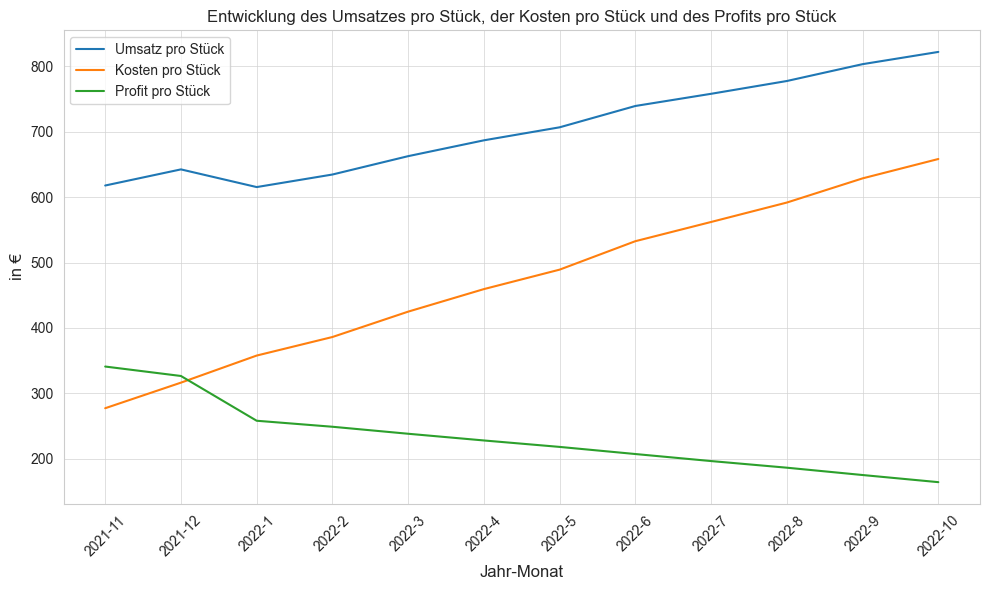

In [40]:
# Visualisierung der Entwicklung des Umsatzes pro Stück, der Kosten pro Stück und des Profits pro Stück
fig, ax = plt.subplots(figsize=(10, 6))

# Daten plotten
ax.plot(df_development_per_piece['year'].astype(str) + '-' + df_development_per_piece['month'].astype(str), df_development_per_piece['revenue_per_piece'])
ax.plot(df_development_per_piece['year'].astype(str) + '-' + df_development_per_piece['month'].astype(str), df_development_per_piece['cost_per_piece'])
ax.plot(df_development_per_piece['year'].astype(str) + '-' + df_development_per_piece['month'].astype(str), df_development_per_piece['profit_per_piece'])

# Grid hinzufuegen
ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)
ax.set_ylabel('in €', fontsize=12)
ax.set_title('Entwicklung des Umsatzes pro Stück, der Kosten pro Stück und des Profits pro Stück')

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Legende hinzufuegen
ax.legend(['Umsatz pro Stück', 'Kosten pro Stück', 'Profit pro Stück'])

# Diagramm anzeigen
plt.tight_layout()
plt.show()

In [41]:
# Veränderung vom Anfang bis zum Ende des Zeitraums in Prozent berechnen 

# Neues Dataframe mit erstellen (KPI, Change in %)
df_kpi_per_piece = pd.DataFrame(columns=['kpi', 'change_in_percent'])

# Liste mit den KPIs erstellen
kpi = ['revenue_per_piece', 'cost_per_piece', 'profit_per_piece']

# Berechnung der Veränderung in Prozent
for i in kpi:
    change = (df_development_per_piece[i].iloc[-1] / df_development_per_piece[i].iloc[0] - 1) * 100
    df_kpi_per_piece.loc[len(df_kpi_per_piece)] = [i, change]

df_kpi_per_piece

,kpi,change_in_percent
0,revenue_per_piece,33.09
1,cost_per_piece,137.68
2,profit_per_piece,-51.92


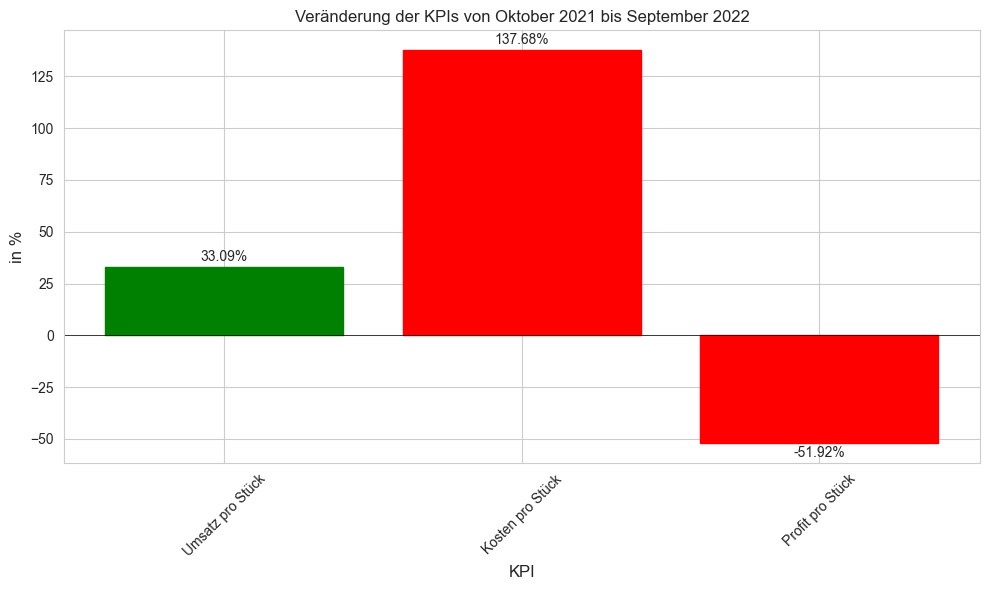

In [42]:
# Visualisierung der Veränderung der KPIs als Säulendiagramm
fig, ax = plt.subplots(figsize=(10, 6))

# Daten plotten
bars = ax.bar(df_kpi_per_piece['kpi'], df_kpi_per_piece['change_in_percent'])

# Achsenbeschriftung und Titel hinzufuegen
ax.set_title('Veränderung der KPIs von Oktober 2021 bis September 2022')
ax.set_xlabel('KPI', fontsize=12)
ax.set_ylabel('in %', fontsize=12)

# Linie bei 0 hinzufuegen
ax.axhline(0, color='black', linewidth=0.5)

# Farbe der Säulen anpassen
ax.patches[0].set_color('green')
ax.patches[1].set_color('red')
ax.patches[2].set_color('red')

# Beschriftung der Säulen hinzufuegen
ax.bar_label(bars, fmt='%.2f%%', padding=2)

# X-Achsenbeschriftung auf Deutsch ("Umsatz pro Stück", "Kosten pro Stück", "Profit pro Stück")
ax.xaxis.set_ticks(np.arange(3))
ax.set_xticklabels(['Umsatz pro Stück', 'Kosten pro Stück', 'Profit pro Stück'])
plt.xticks(rotation=45)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

# 5) Detaillierte Analyse

## Hypothese 1: Preise haben sich verändert

In [43]:
df_preise

,year,product,price
0,2021,Tablet Pro,999
1,2022,Tablet Pro,999
2,2021,Tablet Mini,680
3,2022,Tablet Mini,550
4,2021,Tablet Basic,529
5,2022,Tablet Basic,499


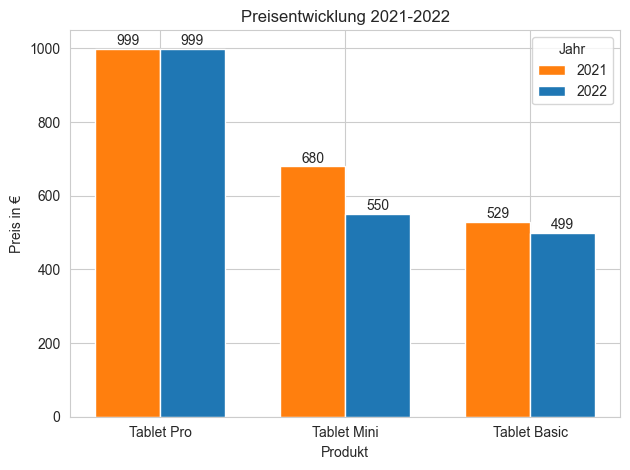

In [44]:
# Visualisierung der Entwicklung der Preise nach Produkte

# Breite der Balken festlegen
bar_width = 0.35

# Einzigartige Produkte und Jahre
products = df_preise['product'].unique()
years = df_preise['year'].unique()

# Farben für jedes Jahr
colors = ['tab:orange', 'tab:blue']

# Diagramm erstellen
fig, ax = plt.subplots()

# Balken für jedes Produkt und Jahr zeichnen
for i, product in enumerate(products):
    for j, year in enumerate(years):
        # Daten für das Produkt und Jahr filtern
        price = df_preise[(df_preise['product'] == product) & (df_preise['year'] == year)]['price'].values[0]
        # Balken zeichnen
        bar = ax.bar(i + j * bar_width, price, width=bar_width, label=f'{year}' if i == 0 else "", color=colors[j])
        # Preis über dem Balken anzeigen
        ax.text(bar[0].get_x() + bar[0].get_width() / 2, price + 10, f'{price}', ha='center')

# Achsenbeschriftungen
ax.set_xlabel('Produkt')
ax.set_ylabel('Preis in €')
ax.set_title('Preisentwicklung 2021-2022')

# X-Achsen-Ticks setzen
ax.set_xticks(np.arange(len(products)) + bar_width / 2)
ax.set_xticklabels(products)

# Legende hinzufügen
ax.legend(title='Jahr')

# Diagramm anzeigen
plt.tight_layout()
plt.show()


In [45]:
# Grupperien des durchschnittliche Preises monatlich über beide Jahre hinweg
preis_pro_monat = df_sales.groupby(['year', 'month']).agg({"price" : "mean"})
preis_pro_monat.reset_index(inplace=True)
preis_pro_monat

,year,month,price
0,2021,11,648.20
1,2021,12,676.00
2,2022,1,648.92
3,2022,2,670.96
4,2022,3,698.52
5,2022,4,721.66
6,2022,5,743.54
7,2022,6,771.64
8,2022,7,791.28
9,2022,8,809.30


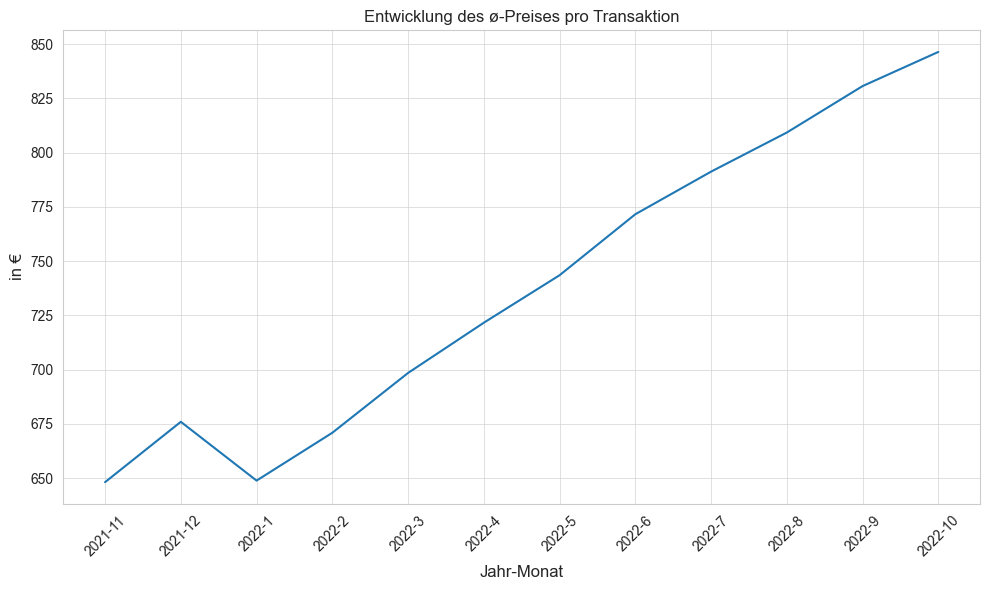

In [46]:
# Visualisierung der Entwicklung des durchschnittlichen Preises monatlich über beide Jahre hinweg
fig, ax = plt.subplots(figsize=(10, 6))

# Daten plotten
ax.plot(preis_pro_monat['year'].astype(str) + '-' + preis_pro_monat['month'].astype(str), preis_pro_monat['price'])

# Grid hinzufuegen
ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)
ax.set_ylabel('in €', fontsize=12)
ax.set_title('Entwicklung des ø-Preises pro Transaktion')

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

- Der durchschnittliche Preis je Transaktion ist gestiegen. Dies liegt daran, dass das teurere Tablet Pro sich im Laufe des Betrachtungszeitraum mehr verkauft hat als die anderen günstigeren Produkte.

## Hypothese 2: Menge an verkauften Produkten ist gesunken

In [47]:
# Anzahl verkaufter Produkte pro Monat
menge_pro_monat = df_sales.groupby(['year', 'month']).agg({"amount" : "sum"})
menge_pro_monat.reset_index(inplace=True)
menge_pro_monat

,year,month,amount
0,2021,11,61277
1,2021,12,65326
2,2022,1,64617
3,2022,2,61855
4,2022,3,68756
5,2022,4,65883
6,2022,5,70301
7,2022,6,69096
8,2022,7,70883
9,2022,8,73857


In [48]:
# Summe der Transaktionen pro Monat
transaktionen_pro_monat = df_sales.groupby(['year', 'month']).agg({"transaction_id" : "count"})
transaktionen_pro_monat.reset_index(inplace=True)
transaktionen_pro_monat

,year,month,transaction_id
0,2021,11,23453
1,2021,12,25174
2,2022,1,26108
3,2022,2,24665
4,2022,3,27533
5,2022,4,27479
6,2022,5,29273
7,2022,6,29123
8,2022,7,30798
9,2022,8,31500


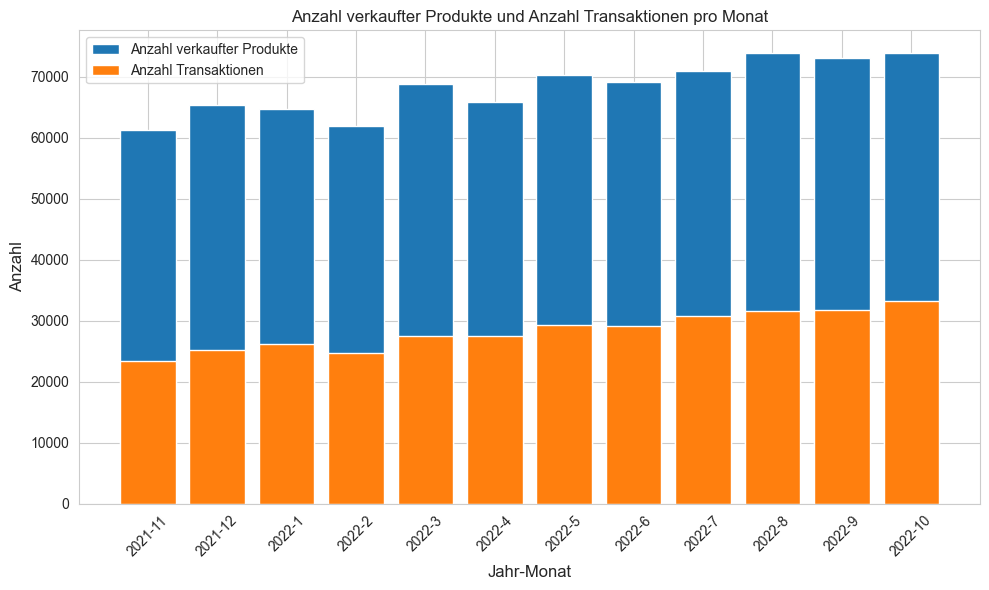

In [49]:
# Beide als Barplot darstellen
fig, ax = plt.subplots(figsize=(10, 6))

# Daten plotten
ax.bar(menge_pro_monat['year'].astype(str) + '-' + menge_pro_monat['month'].astype(str), menge_pro_monat['amount'])
ax.bar(transaktionen_pro_monat['year'].astype(str) + '-' + transaktionen_pro_monat['month'].astype(str), transaktionen_pro_monat['transaction_id'])

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)
ax.set_ylabel('Anzahl', fontsize=12)
ax.set_title('Anzahl verkaufter Produkte und Anzahl Transaktionen pro Monat')

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Legende hinzufuegen
ax.legend(['Anzahl verkaufter Produkte', 'Anzahl Transaktionen'])

# Diagramm anzeigen
plt.tight_layout()
plt.show()

In [50]:
# Durchschnittliche Anzahl der verkauften Produkte pro Transaktion
avg_menge_pro_monat = df_sales.groupby(['year', 'month']).agg({"amount" : "mean"})
avg_menge_pro_monat.reset_index(inplace=True)
avg_menge_pro_monat

,year,month,amount
0,2021,11,2.61
1,2021,12,2.59
2,2022,1,2.47
3,2022,2,2.51
4,2022,3,2.50
5,2022,4,2.40
6,2022,5,2.40
7,2022,6,2.37
8,2022,7,2.30
9,2022,8,2.34


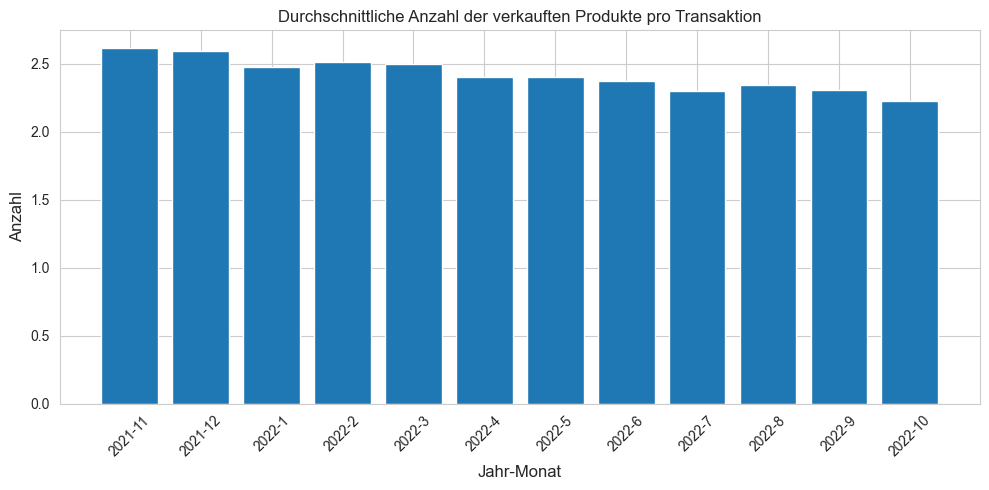

In [51]:
# Visualisierung der Entwicklung der durchschnittlichen Anzahl der verkauften Produkte pro Transaktion
fig, ax = plt.subplots(figsize=(10, 5))

# Daten plotten
ax.bar(avg_menge_pro_monat['year'].astype(str) + '-' + avg_menge_pro_monat['month'].astype(str), avg_menge_pro_monat['amount'])

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)
ax.set_ylabel('Anzahl', fontsize=12)
ax.set_title('Durchschnittliche Anzahl der verkauften Produkte pro Transaktion')

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

**Erkenntnisse:**
- Die Menge verkaufter Artikel und Anzahl Transaktionen sind leicht gestiegen
- Die durchschnittliche Anzahl der verkauften Produkte je Transaktion ist aber etwas gesunken

## Hypothese 3: Regionen haben unterschiedlich gut performt

In [52]:
# Umsatz, Kosten und Gewinn pro Monat für Region A
df_sales_a = df_sales[df_sales['region'] == 'A'].groupby(pd.Grouper(key='date', freq='M')).agg({'amount': 'sum', 'revenue': 'sum', 'cost_total': 'sum', 'profit_total': 'sum'})

# Umsatz, Kosten und Gewinn pro Monat für Region B
df_sales_b = df_sales[df_sales['region'] == 'B'].groupby(pd.Grouper(key='date', freq='M')).agg({'amount': 'sum', 'revenue': 'sum', 'cost_total': 'sum', 'profit_total': 'sum'})

# Umsatz, Kosten und Gewinn pro Monat für Region C
df_sales_c = df_sales[df_sales['region'] == 'C'].groupby(pd.Grouper(key='date', freq='M')).agg({'amount': 'sum', 'revenue': 'sum', 'cost_total': 'sum', 'profit_total': 'sum'})

# Umsatz, Kosten und Gewinn pro Monat für Region D
df_sales_d = df_sales[df_sales['region'] == 'D'].groupby(pd.Grouper(key='date', freq='M')).agg({'amount': 'sum', 'revenue': 'sum', 'cost_total': 'sum', 'profit_total': 'sum'})

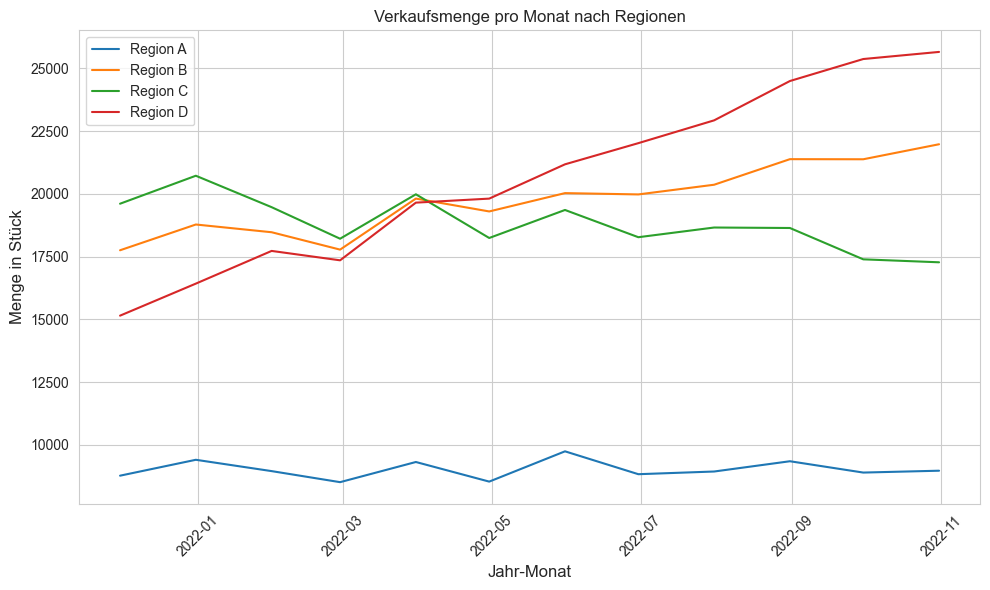

In [53]:
# Verkaufsmenge plotten
fig, ax = plt.subplots(figsize=(10, 6))

# Daten plotten
ax.plot(df_sales_a.index, df_sales_a['amount'])
ax.plot(df_sales_b.index, df_sales_b['amount'])
ax.plot(df_sales_c.index, df_sales_c['amount'])
ax.plot(df_sales_d.index, df_sales_d['amount'])

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)
ax.set_ylabel('Menge in Stück', fontsize=12)
ax.set_title('Verkaufsmenge pro Monat nach Regionen')

# Legende hinzufuegen
ax.legend(['Region A', 'Region B', 'Region C', 'Region D'])

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

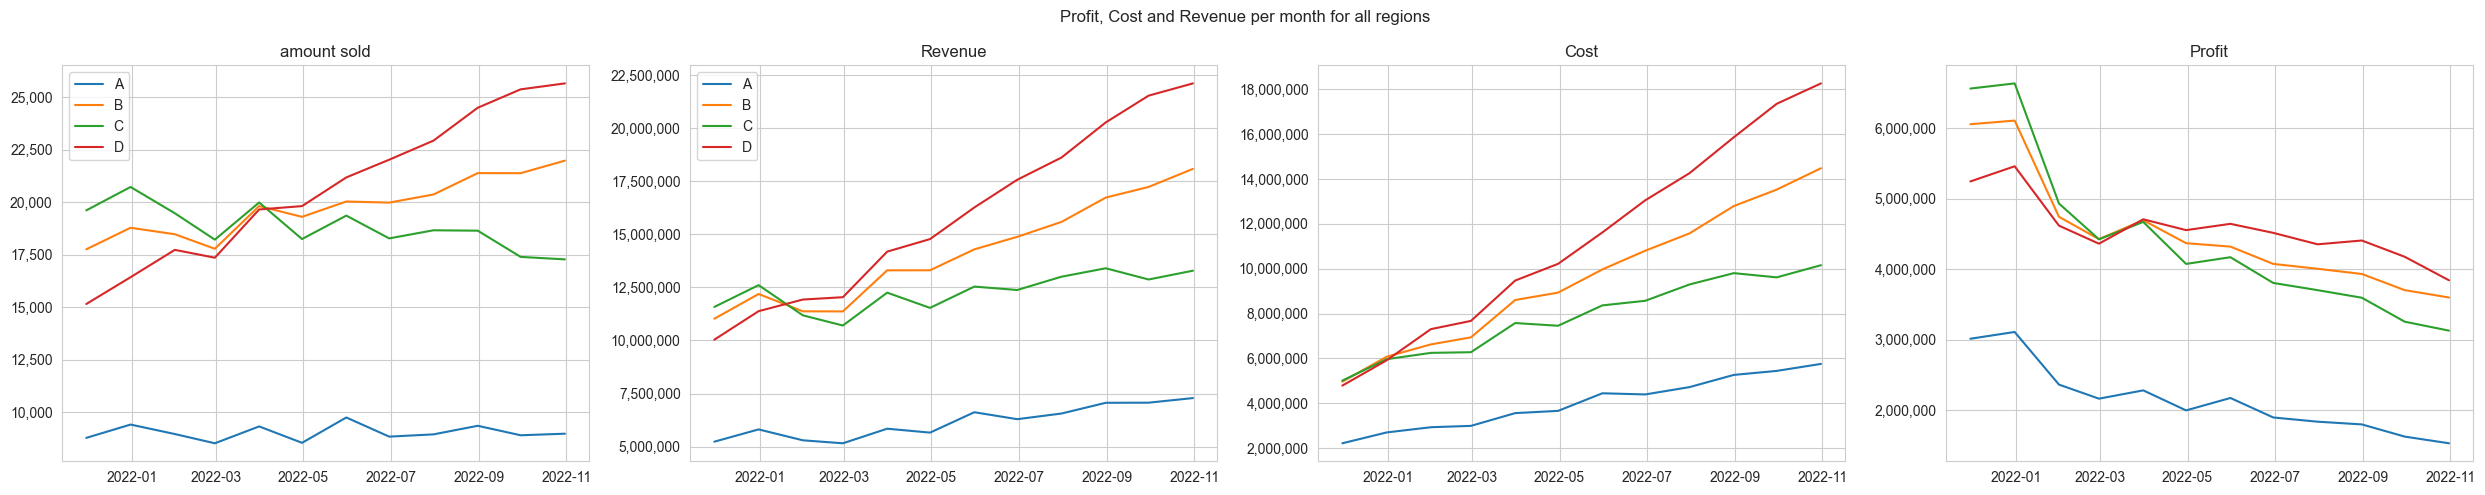

In [54]:
# Umsatz, Kosten und Gewinn pro Monat für alle Regionen jeweils als Subplot visualisieren und alle Subplots zusammenfassen
fig, axes = plt.subplots(1, 4, figsize=(25, 5))
fig.suptitle('Profit, Cost and Revenue per month for all regions')

axes[0].plot(df_sales_a['amount'], label='A')
axes[0].plot(df_sales_b['amount'], label='B')
axes[0].plot(df_sales_c['amount'], label='C')
axes[0].plot(df_sales_d['amount'], label='D')
axes[0].set_title('amount sold')
axes[0].legend()

axes[1].plot(df_sales_a['revenue'], label='A')
axes[1].plot(df_sales_b['revenue'], label='B')
axes[1].plot(df_sales_c['revenue'], label='C')
axes[1].plot(df_sales_d['revenue'], label='D')
axes[1].set_title('Revenue')
axes[1].legend()

axes[2].plot(df_sales_a['cost_total'], label='A')
axes[2].plot(df_sales_b['cost_total'], label='B')
axes[2].plot(df_sales_c['cost_total'], label='C')
axes[2].plot(df_sales_d['cost_total'], label='D')
axes[2].set_title('Cost')

axes[3].plot(df_sales_a['profit_total'], label='A')
axes[3].plot(df_sales_b['profit_total'], label='B')
axes[3].plot(df_sales_c['profit_total'], label='C')
axes[3].plot(df_sales_d['profit_total'], label='D')
axes[3].set_title('Profit')

# y-Achse in Millionen formatieren
for ax in axes:
    ax.yaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.tight_layout()

- Alle Regionen haben den gleichen Abwärtstrend beim Gewinn durchgemacht
    - Region C hatte die größte Gewinnsenkung
- Region D hat im Vergleich am besten performt

In [55]:
# Verkäufe je Region und Kanal
df_sales_region_channel = df_sales.groupby(["year", "month", 'region', 'channel']).agg({"amount" : "sum"})
df_sales_region_channel.reset_index(inplace=True)
df_sales_region_channel

,year,month,region,channel,amount
0,2021,11,A,online,5340
1,2021,11,A,phone,1765
2,2021,11,A,store,1669
3,2021,11,B,online,6967
4,2021,11,B,phone,5969
...,...,...,...,...,...
139,2022,10,C,phone,6183
140,2022,10,C,store,7766
141,2022,10,D,online,3667
142,2022,10,D,phone,8935


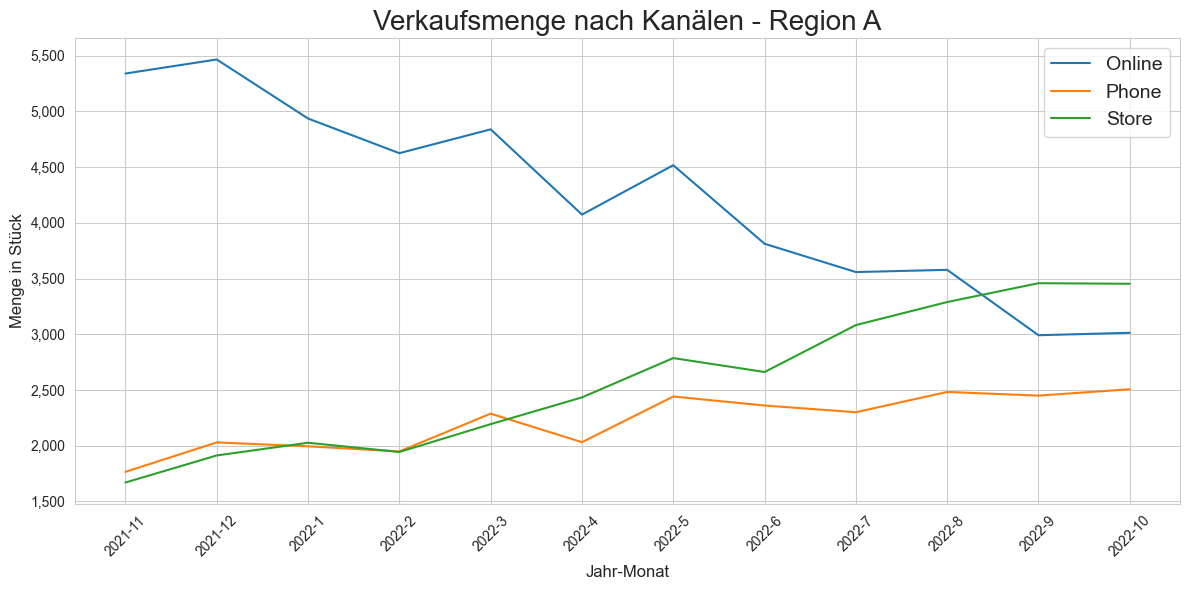

In [56]:
# Region A
df_sales_region_channel_a = df_sales_region_channel[df_sales_region_channel['region'] == 'A']
df_sales_region_channel_a_online = df_sales_region_channel_a[df_sales_region_channel_a['channel'] == 'online']
df_sales_region_channel_a_phone = df_sales_region_channel_a[df_sales_region_channel_a['channel'] == 'phone']
df_sales_region_channel_a_store = df_sales_region_channel_a[df_sales_region_channel_a['channel'] == 'store']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Daten plotten
ax.plot(df_sales_region_channel_a_online['year'].astype(str) + '-' + df_sales_region_channel_a_online['month'].astype(str), df_sales_region_channel_a_online['amount'])
ax.plot(df_sales_region_channel_a_phone['year'].astype(str) + '-' + df_sales_region_channel_a_phone['month'].astype(str), df_sales_region_channel_a_phone['amount'])
ax.plot(df_sales_region_channel_a_store['year'].astype(str) + '-' + df_sales_region_channel_a_store['month'].astype(str), df_sales_region_channel_a_store['amount'])

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)

# y-Achse in Millionen formatieren
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax.set_ylabel('Menge in Stück', fontsize=12)
ax.set_title('Verkaufsmenge nach Kanälen - Region A', fontsize=20)

# Legende hinzufuegen
ax.legend(['Online', 'Phone', 'Store'], fontsize=14)

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Diagramm anzeigen
plt.tight_layout()
plt.show()


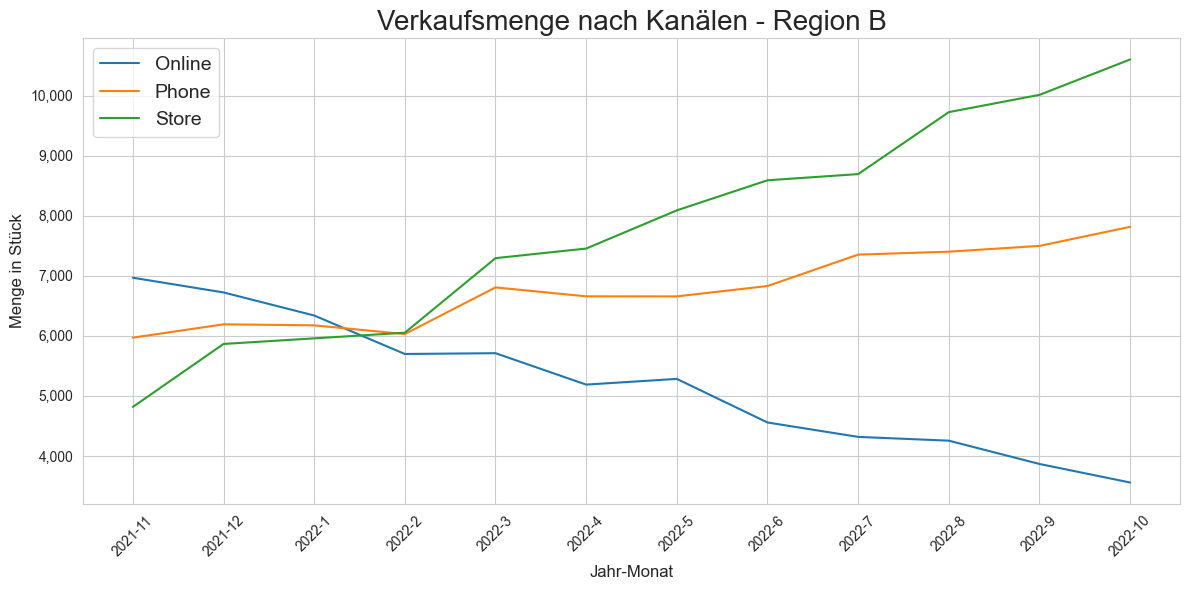

In [57]:
# Region B
df_sales_region_channel_b = df_sales_region_channel[df_sales_region_channel['region'] == 'B']

df_sales_region_channel_b_online = df_sales_region_channel_b[df_sales_region_channel_b['channel'] == 'online']
df_sales_region_channel_b_phone = df_sales_region_channel_b[df_sales_region_channel_b['channel'] == 'phone']
df_sales_region_channel_b_store = df_sales_region_channel_b[df_sales_region_channel_b['channel'] == 'store']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Daten plotten
ax.plot(df_sales_region_channel_b_online['year'].astype(str) + '-' + df_sales_region_channel_b_online['month'].astype(str), df_sales_region_channel_b_online['amount'])
ax.plot(df_sales_region_channel_b_phone['year'].astype(str) + '-' + df_sales_region_channel_b_phone['month'].astype(str), df_sales_region_channel_b_phone['amount'])
ax.plot(df_sales_region_channel_b_store['year'].astype(str) + '-' + df_sales_region_channel_b_store['month'].astype(str), df_sales_region_channel_b_store['amount'])

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)

# y-Achse in Millionen formatieren
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax.set_ylabel('Menge in Stück', fontsize=12)
ax.set_title('Verkaufsmenge nach Kanälen - Region B', fontsize=20)

# Legende hinzufuegen (groß)
ax.legend(['Online', 'Phone', 'Store'], fontsize=14)

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

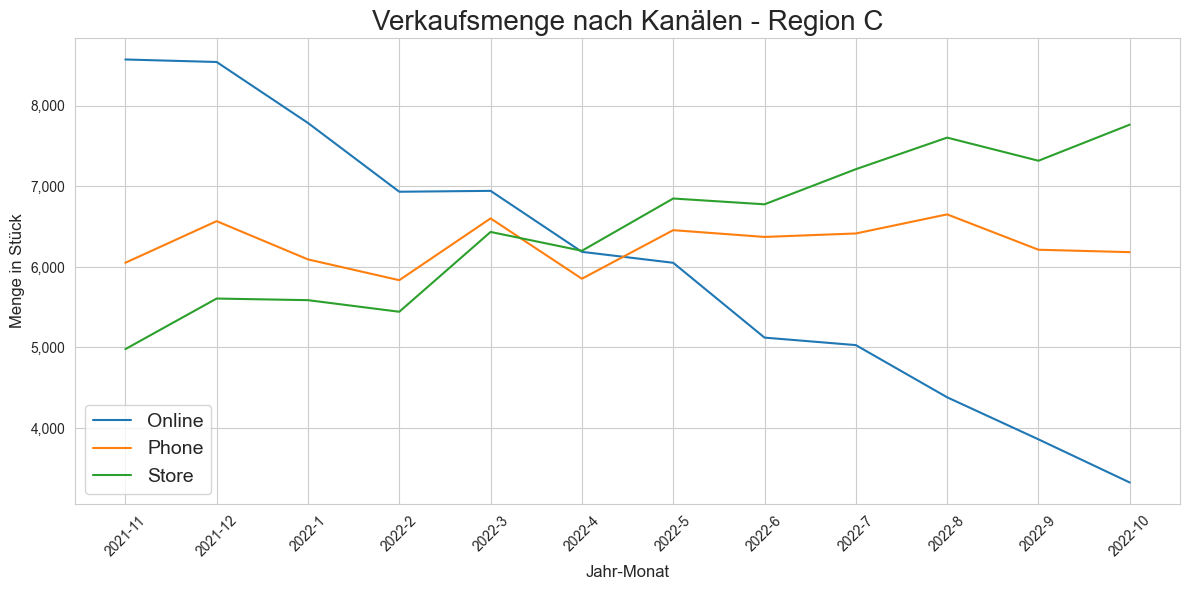

In [58]:
# Region C
df_sales_region_channel_c = df_sales_region_channel[df_sales_region_channel['region'] == 'C']

df_sales_region_channel_c_online = df_sales_region_channel_c[df_sales_region_channel_c['channel'] == 'online']
df_sales_region_channel_c_phone = df_sales_region_channel_c[df_sales_region_channel_c['channel'] == 'phone']
df_sales_region_channel_c_store = df_sales_region_channel_c[df_sales_region_channel_c['channel'] == 'store']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Daten plotten
ax.plot(df_sales_region_channel_c_online['year'].astype(str) + '-' + df_sales_region_channel_c_online['month'].astype(str), df_sales_region_channel_c_online['amount'])
ax.plot(df_sales_region_channel_c_phone['year'].astype(str) + '-' + df_sales_region_channel_c_phone['month'].astype(str), df_sales_region_channel_c_phone['amount'])
ax.plot(df_sales_region_channel_c_store['year'].astype(str) + '-' + df_sales_region_channel_c_store['month'].astype(str), df_sales_region_channel_c_store['amount'])

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)

# y-Achse in Millionen formatieren
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax.set_ylabel('Menge in Stück', fontsize=12)
ax.set_title('Verkaufsmenge nach Kanälen - Region C', fontsize=20)

# Legende hinzufuegen
ax.legend(['Online', 'Phone', 'Store'], fontsize=14)

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

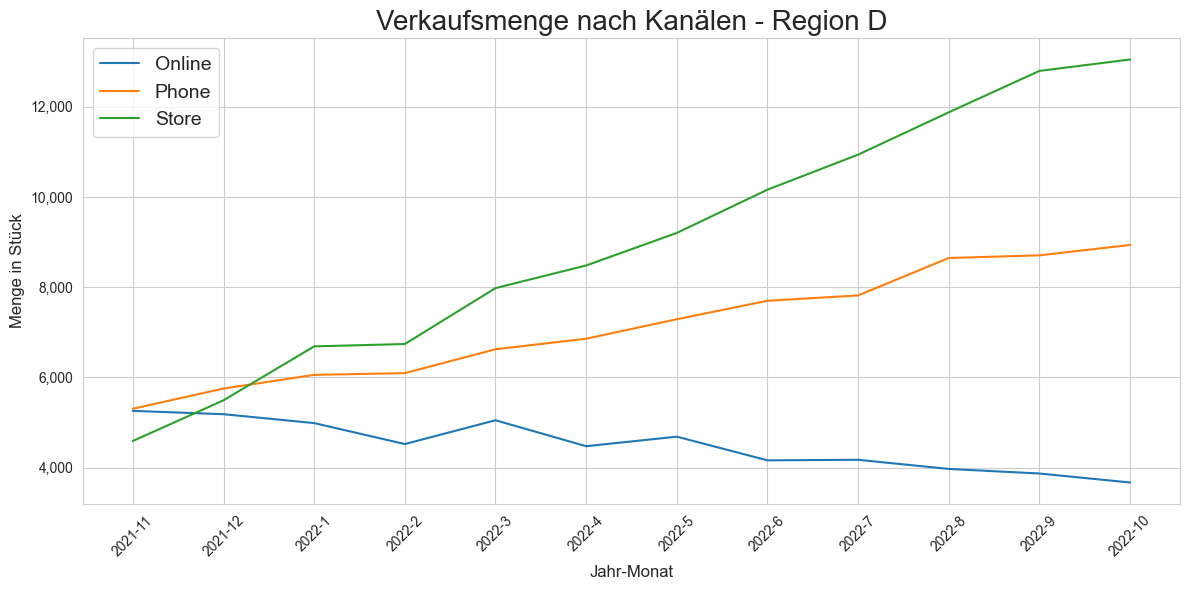

In [59]:
# Region D
df_sales_region_channel_d = df_sales_region_channel[df_sales_region_channel['region'] == 'D']

df_sales_region_channel_d_online = df_sales_region_channel_d[df_sales_region_channel_d['channel'] == 'online']
df_sales_region_channel_d_phone = df_sales_region_channel_d[df_sales_region_channel_d['channel'] == 'phone']
df_sales_region_channel_d_store = df_sales_region_channel_d[df_sales_region_channel_d['channel'] == 'store']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Daten plotten
ax.plot(df_sales_region_channel_d_online['year'].astype(str) + '-' + df_sales_region_channel_d_online['month'].astype(str), df_sales_region_channel_d_online['amount'])
ax.plot(df_sales_region_channel_d_phone['year'].astype(str) + '-' + df_sales_region_channel_d_phone['month'].astype(str), df_sales_region_channel_d_phone['amount'])
ax.plot(df_sales_region_channel_d_store['year'].astype(str) + '-' + df_sales_region_channel_d_store['month'].astype(str), df_sales_region_channel_d_store['amount'])

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)

# y-Achse in Millionen formatieren
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax.set_ylabel('Menge in Stück', fontsize=12)
ax.set_title('Verkaufsmenge nach Kanälen - Region D', fontsize=20)

# Legende hinzufuegen
ax.legend(['Online', 'Phone', 'Store'], fontsize=14)

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

## Hypothese 4: Vertriebskanäle haben unterschiedlich performt

In [60]:
# Umsatz, Kosten und Gewinn pro Woche für Verkaufskanal Online
df_sales_online = df_sales[df_sales['channel'] == 'online'].groupby(pd.Grouper(key='date', freq='M')).agg({'amount': 'sum', 'revenue': 'sum', 'cost_total': 'sum', 'profit_total': 'sum'})

# Umsatz, Kosten und Gewinn pro Woche für Verkaufskanal Phone
df_sales_phone = df_sales[df_sales['channel'] == 'phone'].groupby(pd.Grouper(key='date', freq='M')).agg({'amount': 'sum', 'revenue': 'sum', 'cost_total': 'sum', 'profit_total': 'sum'})

# Umsatz, Kosten und Gewinn pro Woche für Verkaufskanal Store
df_sales_store = df_sales[df_sales['channel'] == 'store'].groupby(pd.Grouper(key='date', freq='M')).agg({'amount': 'sum', 'revenue': 'sum', 'cost_total': 'sum', 'profit_total': 'sum'})

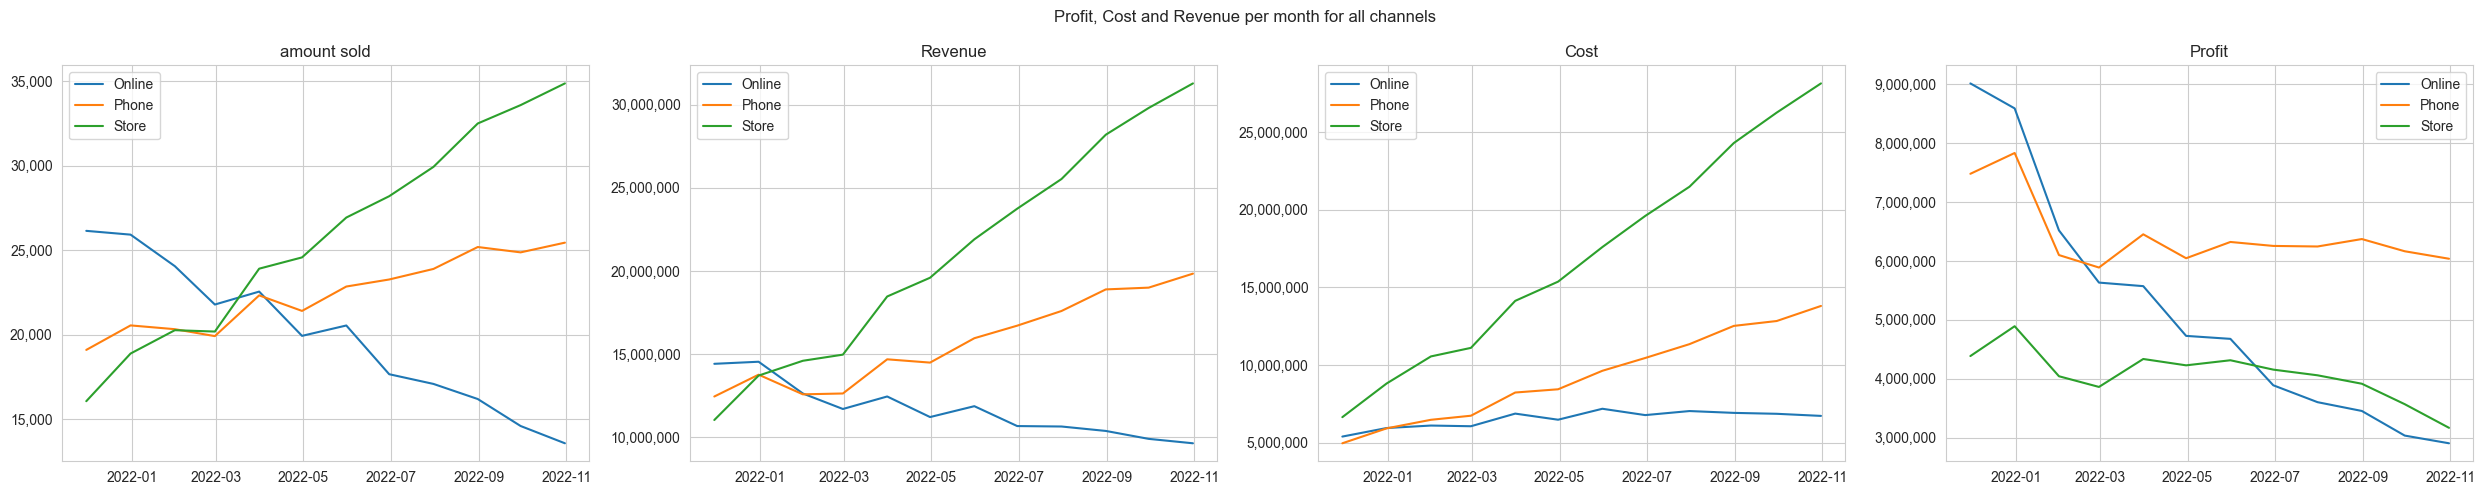

In [61]:
# Umsatz, Kosten und Gewinn pro Woche für alle Verkaufskanäle jeweils als Subplot visualisieren und alle Subplots zusammenfassen
fig, axes = plt.subplots(1, 4, figsize=(25, 5))
fig.suptitle('Profit, Cost and Revenue per month for all channels')

axes[0].plot(df_sales_online['amount'], label='Online')
axes[0].plot(df_sales_phone['amount'], label='Phone')
axes[0].plot(df_sales_store['amount'], label='Store')
axes[0].set_title('amount sold')
axes[0].legend()

axes[1].plot(df_sales_online['revenue'], label='Online')
axes[1].plot(df_sales_phone['revenue'], label='Phone')
axes[1].plot(df_sales_store['revenue'], label='Store')
axes[1].set_title('Revenue')
axes[1].legend()

axes[2].plot(df_sales_online['cost_total'], label='Online')
axes[2].plot(df_sales_phone['cost_total'], label='Phone')
axes[2].plot(df_sales_store['cost_total'], label='Store')
axes[2].set_title('Cost')
axes[2].legend()

axes[3].plot(df_sales_online['profit_total'], label='Online')
axes[3].plot(df_sales_phone['profit_total'], label='Phone')
axes[3].plot(df_sales_store['profit_total'], label='Store')
axes[3].set_title('Profit')
axes[3].legend()

# y-Achse in Millionen formatieren
for ax in axes:
    ax.yaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
plt.tight_layout()

- Online hat den größten Gewinnverlust erfahren

### Vergleich der Online-Kanäle der Regionen A bis D

In [62]:
# Anzahl verkaufter Produkte, Umsatz, Kosten und Gewinn pro Monat für die Regionen A, B, C und D in dem Kanal Online
df_sales_online_a = df_sales[(df_sales['region'] == 'A') & (df_sales['channel'] == 'online')].groupby(pd.Grouper(key='date', freq='M')).agg({"transaction_id": "count", 'amount': 'sum', 'revenue': 'sum', 'cost_total': 'sum', 'profit_total': 'sum'})

df_sales_online_b = df_sales[(df_sales['region'] == 'B') & (df_sales['channel'] == 'online')].groupby(pd.Grouper(key='date', freq='M')).agg({"transaction_id": "count", 'amount': 'sum', 'revenue': 'sum', 'cost_total': 'sum', 'profit_total': 'sum'})

df_sales_online_c = df_sales[(df_sales['region'] == 'C') & (df_sales['channel'] == 'online')].groupby(pd.Grouper(key='date', freq='M')).agg({"transaction_id": "count", 'amount': 'sum', 'revenue': 'sum', 'cost_total': 'sum', 'profit_total': 'sum'})

df_sales_online_d = df_sales[(df_sales['region'] == 'D') & (df_sales['channel'] == 'online')].groupby(pd.Grouper(key='date', freq='M')).agg({"transaction_id": "count", 'amount': 'sum', 'revenue': 'sum', 'cost_total': 'sum', 'profit_total': 'sum'})

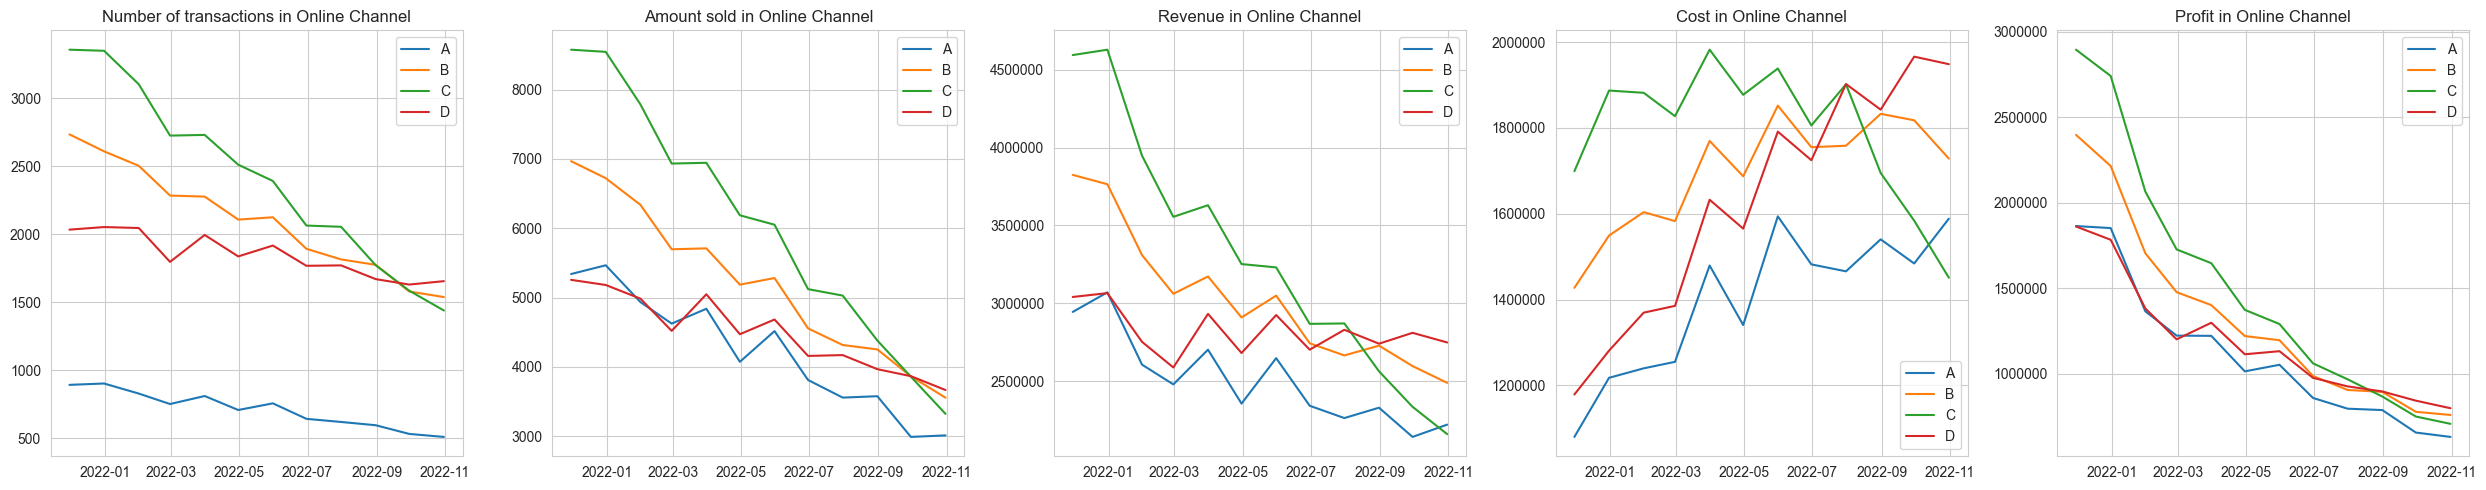

In [63]:
# Verkaufskanal Online für alle Regionen in einem Plot zusammenfassen
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

axes[0].plot(df_sales_online_a['transaction_id'], label='A')
axes[0].plot(df_sales_online_b['transaction_id'], label='B')
axes[0].plot(df_sales_online_c['transaction_id'], label='C')
axes[0].plot(df_sales_online_d['transaction_id'], label='D')
axes[0].set_title('Number of transactions in Online Channel')
axes[0].legend()

axes[1].plot(df_sales_online_a['amount'], label='A')
axes[1].plot(df_sales_online_b['amount'], label='B')
axes[1].plot(df_sales_online_c['amount'], label='C')
axes[1].plot(df_sales_online_d['amount'], label='D')
axes[1].set_title('Amount sold in Online Channel')
axes[1].legend()

axes[2].plot(df_sales_online_a['revenue'], label='A')
axes[2].plot(df_sales_online_b['revenue'], label='B')
axes[2].plot(df_sales_online_c['revenue'], label='C')
axes[2].plot(df_sales_online_d['revenue'], label='D')
axes[2].set_title('Revenue in Online Channel')
axes[2].legend()

axes[3].plot(df_sales_online_a['cost_total'], label='A')
axes[3].plot(df_sales_online_b['cost_total'], label='B')
axes[3].plot(df_sales_online_c['cost_total'], label='C')
axes[3].plot(df_sales_online_d['cost_total'], label='D')
axes[3].set_title('Cost in Online Channel')
axes[3].legend()

axes[4].plot(df_sales_online_a['profit_total'], label='A')
axes[4].plot(df_sales_online_b['profit_total'], label='B')
axes[4].plot(df_sales_online_c['profit_total'], label='C')
axes[4].plot(df_sales_online_d['profit_total'], label='D')
axes[4].set_title('Profit in Online Channel')
axes[4].legend()

# y-Achse ohne wissenschaftliche Notation
for ax in axes:
    ax.ticklabel_format(style='plain', axis='y')
    
plt.tight_layout()

## Hypothese 5: Produkte haben unterschiedlich gut performt

In [64]:
# Anzahl verkaufter Produkte, Umsatz, Kosten und Gewinn pro Monat für Produkt "Tablet Basic"
df_sales_basic = df_sales[df_sales['product'] == 'Tablet Basic'].groupby(pd.Grouper(key='date', freq='M')).agg({'amount': 'sum', 'revenue': 'sum', 'cost_total': 'sum', 'profit_total': 'sum'})

# Anzahl verkaufter Produkte, Umsatz, Kosten und Gewinn pro Monat für Produkt "Tablet Mini"
df_sales_mini = df_sales[df_sales['product'] == 'Tablet Mini'].groupby(pd.Grouper(key='date', freq='M')).agg({'amount': 'sum', 'revenue': 'sum', 'cost_total': 'sum', 'profit_total': 'sum'})

# Anzahl verkaufter Produkte, Umsatz, Kosten und Gewinn pro Monat für Produkt "Tablet Pro"
df_sales_pro = df_sales[df_sales['product'] == 'Tablet Pro'].groupby(pd.Grouper(key='date', freq='M')).agg({'amount': 'sum', 'revenue': 'sum', 'cost_total': 'sum', 'profit_total': 'sum'})

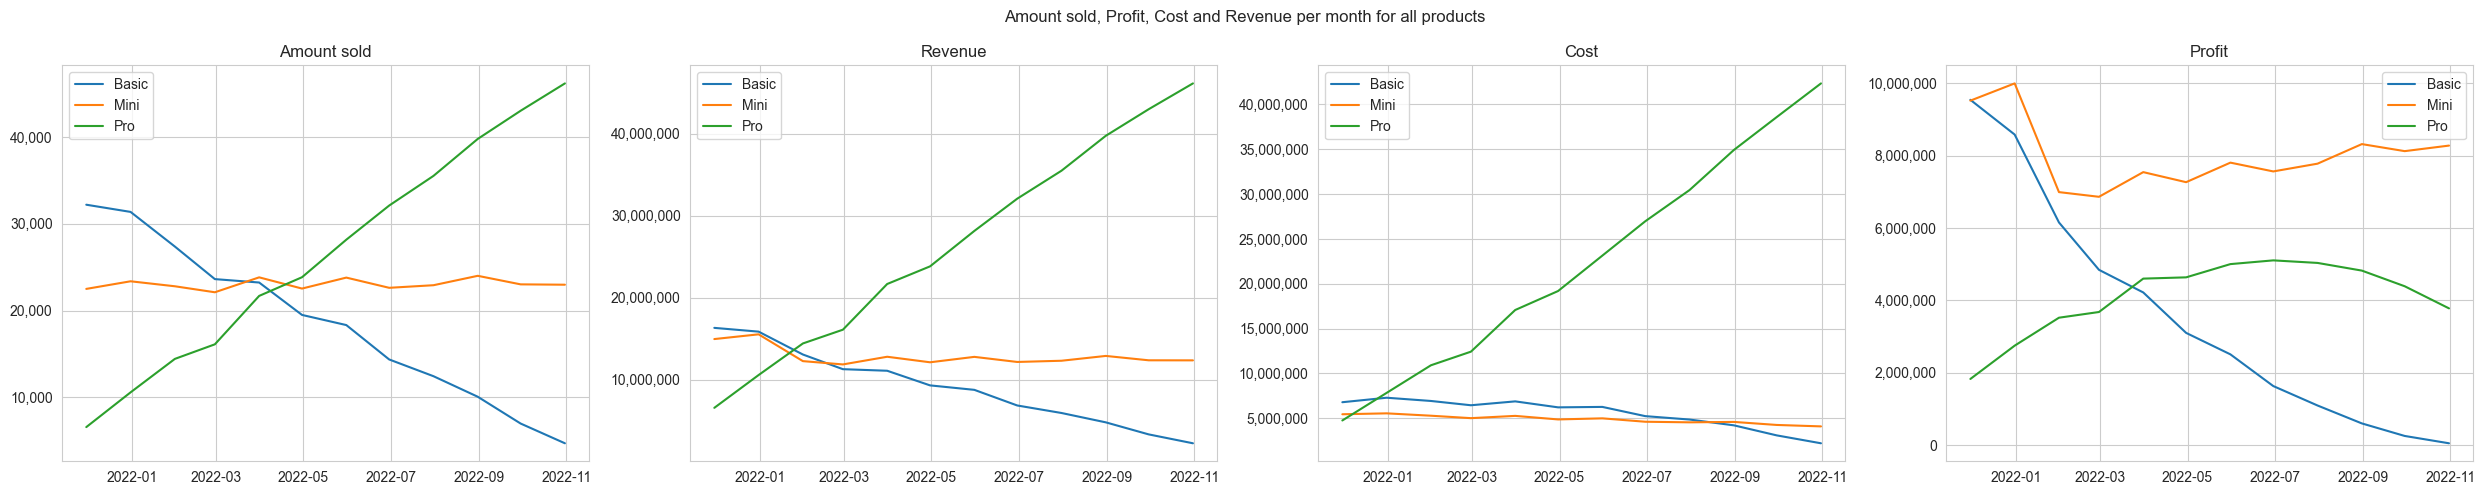

In [65]:
# Umsatz, Kosten und Gewinn pro Monat für alle Produkte jeweils als Subplot visualisieren und alle Subplots zusammenfassen
fig, axes = plt.subplots(1, 4, figsize=(25, 5))
fig.suptitle('Amount sold, Profit, Cost and Revenue per month for all products')

axes[0].plot(df_sales_basic['amount'], label='Basic')
axes[0].plot(df_sales_mini['amount'], label='Mini')
axes[0].plot(df_sales_pro['amount'], label='Pro')
axes[0].set_title('Amount sold')
axes[0].legend()

axes[1].plot(df_sales_basic['revenue'], label='Basic')
axes[1].plot(df_sales_mini['revenue'], label='Mini')
axes[1].plot(df_sales_pro['revenue'], label='Pro')
axes[1].set_title('Revenue')
axes[1].legend()

axes[2].plot(df_sales_basic['cost_total'], label='Basic')
axes[2].plot(df_sales_mini['cost_total'], label='Mini')
axes[2].plot(df_sales_pro['cost_total'], label='Pro')
axes[2].set_title('Cost')
axes[2].legend()

axes[3].plot(df_sales_basic['profit_total'], label='Basic')
axes[3].plot(df_sales_mini['profit_total'], label='Mini')
axes[3].plot(df_sales_pro['profit_total'], label='Pro')
axes[3].set_title('Profit')
axes[3].legend()

# y-Achse in Millionen formatieren
for ax in axes:
    ax.yaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.tight_layout()

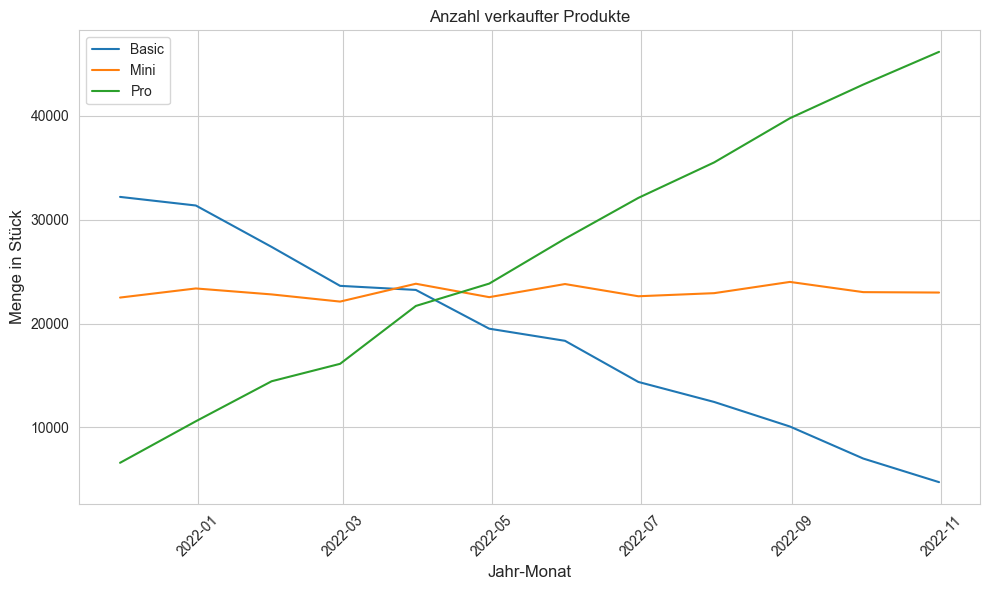

In [66]:
# Anzahl verkaufter Produkte plotten
fig, ax = plt.subplots(figsize=(10, 6))

# Daten plotten
ax.plot(df_sales_basic['amount'], label='Basic')
ax.plot(df_sales_mini['amount'], label='Mini')
ax.plot(df_sales_pro['amount'], label='Pro')

# Jahr und Monat in 

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)
ax.set_ylabel('Menge in Stück', fontsize=12)
ax.set_title('Anzahl verkaufter Produkte')

# Legende hinzufuegen
ax.legend()

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

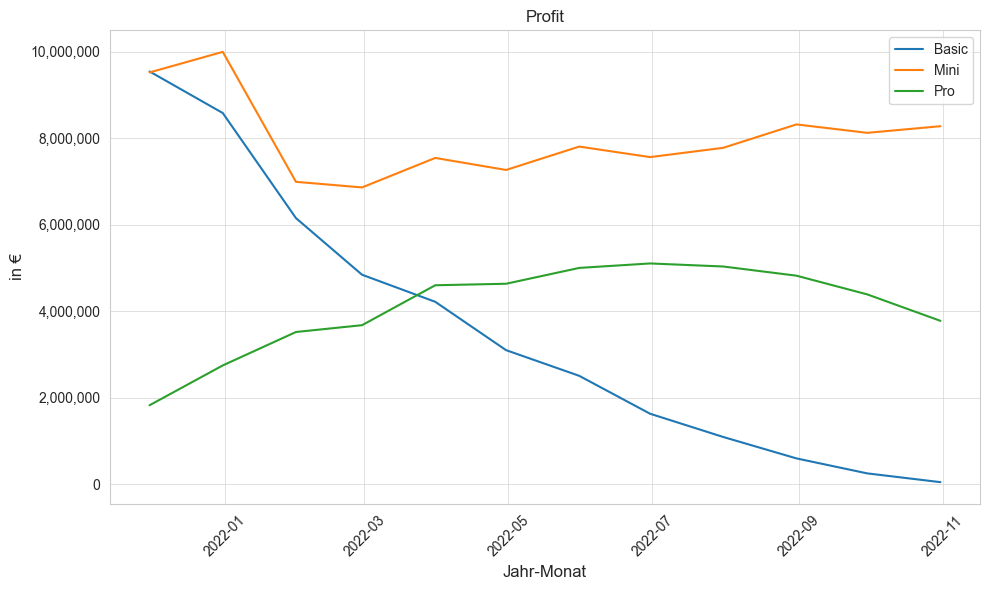

In [67]:
# Profit plotten
fig, ax = plt.subplots(figsize=(10, 6))

# Daten plotten
ax.plot(df_sales_basic['profit_total'], label='Basic')
ax.plot(df_sales_mini['profit_total'], label='Mini')
ax.plot(df_sales_pro['profit_total'], label='Pro')

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)
ax.set_ylabel('in €', fontsize=12)
ax.set_title('Profit')

# y-Achse in Millionen formatieren
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Legende hinzufuegen
ax.legend()

# grid hinzufuegen
ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

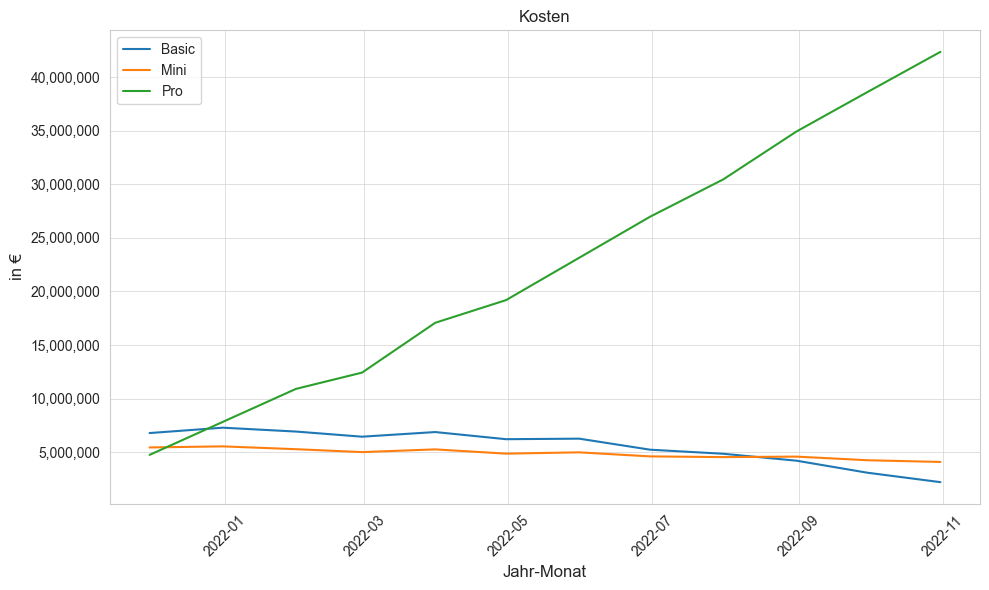

In [68]:
# Kosten plotten
fig, ax = plt.subplots(figsize=(10, 6))

# Daten plotten
ax.plot(df_sales_basic['cost_total'], label='Basic')
ax.plot(df_sales_mini['cost_total'], label='Mini')
ax.plot(df_sales_pro['cost_total'], label='Pro')

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)
ax.set_ylabel('in €', fontsize=12)
ax.set_title('Kosten')

# y-Achse in Millionen formatieren
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# grid hinzufuegen
ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)

# Legende hinzufuegen
ax.legend()

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

In [69]:
# Profit pro Stück
df_profit_per_piece = df_sales.groupby(['year', 'month', "product",]).agg({"profit_total" : "sum", "amount" : "sum"})
df_profit_per_piece.reset_index(inplace=True)
df_profit_per_piece

,year,month,product,profit_total,amount
0,2021,11,Tablet Basic,"9,539,310.83",32195
1,2021,11,Tablet Mini,"9,516,536.79",22499
2,2021,11,Tablet Pro,"1,828,091.02",6583
3,2021,12,Tablet Basic,"8,579,203.58",31366
4,2021,12,Tablet Mini,"9,992,417.97",23376
5,2021,12,Tablet Pro,"2,748,087.50",10584
6,2022,1,Tablet Basic,"6,151,714.70",27377
7,2022,1,Tablet Mini,"6,989,684.71",22802
8,2022,1,Tablet Pro,"3,520,276.59",14438
9,2022,2,Tablet Basic,"4,843,143.12",23627


In [70]:
# Profit pro Stück
df_profit_per_piece['profit_per_piece'] = df_profit_per_piece['profit_total'] / df_profit_per_piece['amount']
df_profit_per_piece

,year,month,product,profit_total,amount,profit_per_piece
0,2021,11,Tablet Basic,"9,539,310.83",32195,296.30
1,2021,11,Tablet Mini,"9,516,536.79",22499,422.98
2,2021,11,Tablet Pro,"1,828,091.02",6583,277.70
3,2021,12,Tablet Basic,"8,579,203.58",31366,273.52
4,2021,12,Tablet Mini,"9,992,417.97",23376,427.46
5,2021,12,Tablet Pro,"2,748,087.50",10584,259.65
6,2022,1,Tablet Basic,"6,151,714.70",27377,224.70
7,2022,1,Tablet Mini,"6,989,684.71",22802,306.54
8,2022,1,Tablet Pro,"3,520,276.59",14438,243.82
9,2022,2,Tablet Basic,"4,843,143.12",23627,204.98


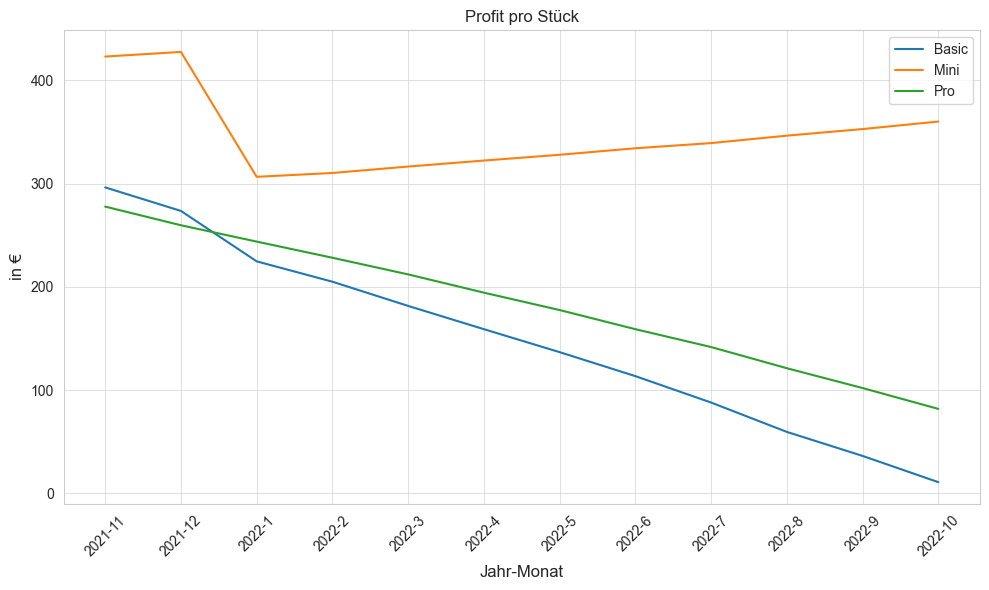

In [71]:
# Profit pro Stück plotten
fig, ax = plt.subplots(figsize=(10, 6))

# Daten plotten
ax.plot(df_profit_per_piece[df_profit_per_piece['product'] == 'Tablet Basic']['year'].astype(str) + '-' + df_profit_per_piece[df_profit_per_piece['product'] == 'Tablet Basic']['month'].astype(str), df_profit_per_piece[df_profit_per_piece['product'] == 'Tablet Basic']['profit_per_piece'])
ax.plot(df_profit_per_piece[df_profit_per_piece['product'] == 'Tablet Mini']['year'].astype(str) + '-' + df_profit_per_piece[df_profit_per_piece['product'] == 'Tablet Mini']['month'].astype(str), df_profit_per_piece[df_profit_per_piece['product'] == 'Tablet Mini']['profit_per_piece'])
ax.plot(df_profit_per_piece[df_profit_per_piece['product'] == 'Tablet Pro']['year'].astype(str) + '-' + df_profit_per_piece[df_profit_per_piece['product'] == 'Tablet Pro']['month'].astype(str), df_profit_per_piece[df_profit_per_piece['product'] == 'Tablet Pro']['profit_per_piece'])

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)
ax.set_ylabel('in €', fontsize=12)
ax.set_title('Profit pro Stück')

# Legende hinzufuegen
ax.legend(['Basic', 'Mini', 'Pro'])

# grid hinzufuegen
ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

In [72]:
# Kosten pro Stück
df_cost_per_piece = df_sales.groupby(['year', 'month', "product",]).agg({"cost_total" : "sum", "amount" : "sum"})
df_cost_per_piece.reset_index(inplace=True)
df_cost_per_piece

,year,month,product,cost_total,amount
0,2021,11,Tablet Basic,"6,784,359.57",32195
1,2021,11,Tablet Mini,"5,441,831.21",22499
2,2021,11,Tablet Pro,"4,748,325.98",6583
3,2021,12,Tablet Basic,"7,285,136.12",31366
4,2021,12,Tablet Mini,"5,542,590.03",23376
5,2021,12,Tablet Pro,"7,825,328.50",10584
6,2022,1,Tablet Basic,"6,924,131.20",27377
7,2022,1,Tablet Mini,"5,279,440.29",22802
8,2022,1,Tablet Pro,"10,903,285.41",14438
9,2022,2,Tablet Basic,"6,445,184.98",23627


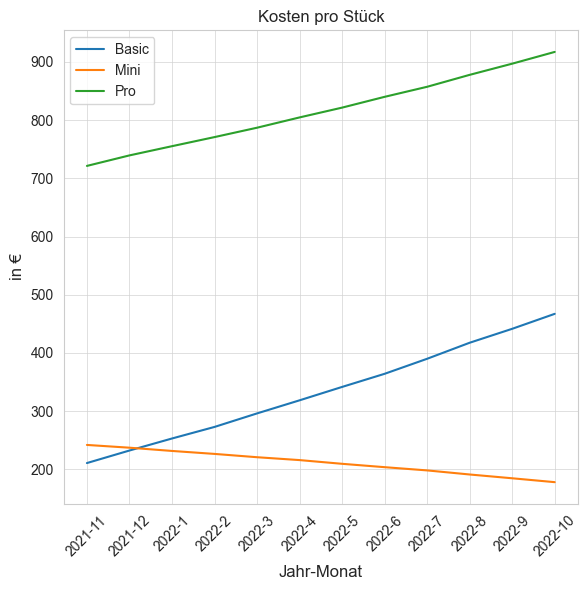

In [73]:
# Kosten pro Stück
df_cost_per_piece['cost_per_piece'] = df_cost_per_piece['cost_total'] / df_cost_per_piece['amount']

# Kosten pro Stück plotten
fig, ax = plt.subplots(figsize=(6, 6))

# Daten plotten
ax.plot(df_cost_per_piece[df_cost_per_piece['product'] == 'Tablet Basic']['year'].astype(str) + '-' + df_cost_per_piece[df_cost_per_piece['product'] == 'Tablet Basic']['month'].astype(str), df_cost_per_piece[df_cost_per_piece['product'] == 'Tablet Basic']['cost_per_piece'])
ax.plot(df_cost_per_piece[df_cost_per_piece['product'] == 'Tablet Mini']['year'].astype(str) + '-' + df_cost_per_piece[df_cost_per_piece['product'] == 'Tablet Mini']['month'].astype(str), df_cost_per_piece[df_cost_per_piece['product'] == 'Tablet Mini']['cost_per_piece'])
ax.plot(df_cost_per_piece[df_cost_per_piece['product'] == 'Tablet Pro']['year'].astype(str) + '-' + df_cost_per_piece[df_cost_per_piece['product'] == 'Tablet Pro']['month'].astype(str), df_cost_per_piece[df_cost_per_piece['product'] == 'Tablet Pro']['cost_per_piece'])

# Achsenbeschriftung und Titel hinzufuegen
ax.set_xlabel('Jahr-Monat', fontsize=12)
ax.set_ylabel('in €', fontsize=12)
ax.set_title('Kosten pro Stück')

# Legende hinzufuegen
ax.legend(['Basic', 'Mini', 'Pro'])

# grid hinzufuegen
ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)

# X-Achsenbeschriftung drehen
plt.xticks(rotation=45)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

In [74]:
# Veränderung von Anfang bis Ende für die Produkte "Tablet Basic", "Tablet Mini" und "Tablet Pro"
def calc_change(df, productname):
    print("Veränderung Anzahl sold", productname, ":", (df.iloc[-1]['amount'] - df.iloc[0]['amount']) / df.iloc[0]['amount'] * 100)
    print("Veränderung Umsatz", productname, ":", (df.iloc[-1]['revenue'] - df.iloc[0]['revenue']) / df.iloc[0]['revenue'] * 100)
    print("Veränderung Kosten", productname, ":", (df.iloc[-1]['cost_total'] - df.iloc[0]['cost_total']) / df.iloc[0]['cost_total'] * 100)
    print("Veränderung Gewinn", productname, ":", (df.iloc[-1]['profit_total'] - df.iloc[0]['profit_total']) / df.iloc[0]['profit_total'] * 100)
    print()


calc_change(df_sales_basic, "Tablet Basic")
calc_change(df_sales_mini, "Tablet Mini")
calc_change(df_sales_pro, "Tablet Pro")

Veränderung Anzahl sold Tablet Basic : -85.34244447895635
Veränderung Umsatz Tablet Basic : -86.18093023980686
Veränderung Kosten Tablet Basic : -67.50920025638224
Veränderung Gewinn Tablet Basic : -99.46026796323004

Veränderung Anzahl sold Tablet Mini : 2.1467620783145915
Veränderung Umsatz Tablet Mini : -17.34833639605604
Veränderung Kosten Tablet Mini : -24.868424323538143
Veränderung Gewinn Tablet Mini : -13.048132434055942

Veränderung Anzahl sold Tablet Pro : 601.2912046179554
Veränderung Umsatz Tablet Pro : 601.2912046179554
Veränderung Kosten Tablet Pro : 791.7200274938408
Veränderung Gewinn Tablet Pro : 106.66696550045928



- Tablet Basic hat sich stark verschlechtert -> Von ca. 9,5 Mio. Gewinn zu 50.000
    - Wurde auch deutlich weniger verkauft
- Gewinn von Tablet Mini hat sich zum Jahreswechsel verschlechtert, aber hat sich danach verbessert und nun ist das profitabelste Produkt
    - Anzahl verkaufter Produkte stagniert, aber leicht gestiegen
- Gewinn von Tablet Pro hat sich stark verbessert, aber Trend ist zum Ende 2022 negativ
    - Anzahl, Umsatz und Kosten sind sehr stark gestiegen
    - Jedoch sind Kosten stärker gestiegen als Umsatz

### Transaktionen mit Verlust

In [75]:
# Transaktionen mit Verlust
df_sales_negative_profit = df_sales[df_sales['profit_total'] < 0]
df_sales_negative_profit

,date,product,discount,amount,tablet_basic,tablet_mini,tablet_pro,cost_basic,cost_mini,cost_pro,transaction_id,region,channel,customer_rating,year,month,week,price,cost,cost_total,revenue,profit_per_piece,profit_total
48806,2022-01-01,Tablet Basic,0.10,9,1,0,0,460.19,0.00,0.00,48806,C,store,8.60,2022,1,52,499,460.19,"4,141.74","4,041.90",-11.09,-99.84
52656,2022-01-05,Tablet Basic,0.10,11,1,0,0,463.36,0.00,0.00,52656,C,store,5.50,2022,1,1,499,463.36,"5,097.00","4,940.10",-14.26,-156.90
52659,2022-01-05,Tablet Basic,0.10,11,1,0,0,483.37,0.00,0.00,52659,C,store,6.30,2022,1,1,499,483.37,"5,317.03","4,940.10",-34.27,-376.93
60396,2022-01-15,Tablet Basic,0.10,8,1,0,0,449.74,0.00,0.00,60396,C,store,5.00,2022,1,2,499,449.74,"3,597.90","3,592.80",-0.64,-5.10
65847,2022-01-21,Tablet Basic,0.10,9,1,0,0,454.23,0.00,0.00,65847,C,store,5.80,2022,1,3,499,454.23,"4,088.04","4,041.90",-5.13,-46.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338986,2022-10-31,Tablet Basic,0.10,3,1,0,0,579.17,0.00,0.00,338986,C,store,4.50,2022,10,44,499,579.17,"1,737.50","1,347.30",-130.07,-390.20
338988,2022-10-31,Tablet Basic,0.10,5,1,0,0,479.17,0.00,0.00,338988,C,phone,3.70,2022,10,44,499,479.17,"2,395.84","2,245.50",-30.07,-150.34
338989,2022-10-31,Tablet Basic,0.00,2,1,0,0,539.17,0.00,0.00,338989,B,store,3.10,2022,10,44,499,539.17,"1,078.34",998.00,-40.17,-80.34
338996,2022-10-31,Tablet Basic,0.10,3,1,0,0,449.17,0.00,0.00,338996,C,online,2.50,2022,10,44,499,449.17,"1,347.52","1,347.30",-0.07,-0.22


In [76]:
# Welche Produkte wurden mit einem Verlust verkauft?
df_sales_negative_profit['product'].unique()

array(['Tablet Basic'], dtype=object)

- Nur mit Tablet Basic wurden Verlustgeschäfte gemacht, insg. 2314 Transaktionen

In [77]:
# Summe des Verlusts
df_sales_negative_profit['profit_total'].sum()

-459619.7704372656

- Mit dem Tablet Basic wurde in 2314 Transaktionen insg. 460 Tsd. EUR Verlust gemacht 

In [78]:
# In welchen Verkaufskanälen und Regionen wurden die Produkte mit negativem Gewinn verkauft und wie oft?
df_sales_negative_profit.groupby(['region', 'channel']).agg({'transaction_id': 'count', 'profit_total': 'sum'})

transaction_id  profit_total
region channel                              
A      online               42    -10,857.51
       phone                21     -3,889.07
       store               177    -32,965.08
B      online              130    -24,764.83
       phone                50     -8,280.72
       store               524   -107,624.33
C      online              162    -28,386.68
       phone                61     -9,026.07
       store               674   -143,836.81
D      online               93    -17,198.17
       phone                40     -9,229.26
       store               340    -63,561.26

- Meistens in den Stores

### Wie oft wurden die Produkte in den einzelnen Regionen verkauft?

In [79]:
# Group by channel, product and sum up amount
sales_per_product_by_channel = df_sales.groupby(['channel', 'product']).agg({'amount': 'sum'})
sales_per_product_by_channel = sales_per_product_by_channel.reset_index()
sales_per_product_by_channel

,channel,product,amount
0,online,Tablet Basic,141081
1,online,Tablet Mini,62273
2,online,Tablet Pro,36558
3,phone,Tablet Basic,41819
4,phone,Tablet Mini,133669
5,phone,Tablet Pro,93539
6,store,Tablet Basic,41340
7,store,Tablet Mini,80573
8,store,Tablet Pro,187896


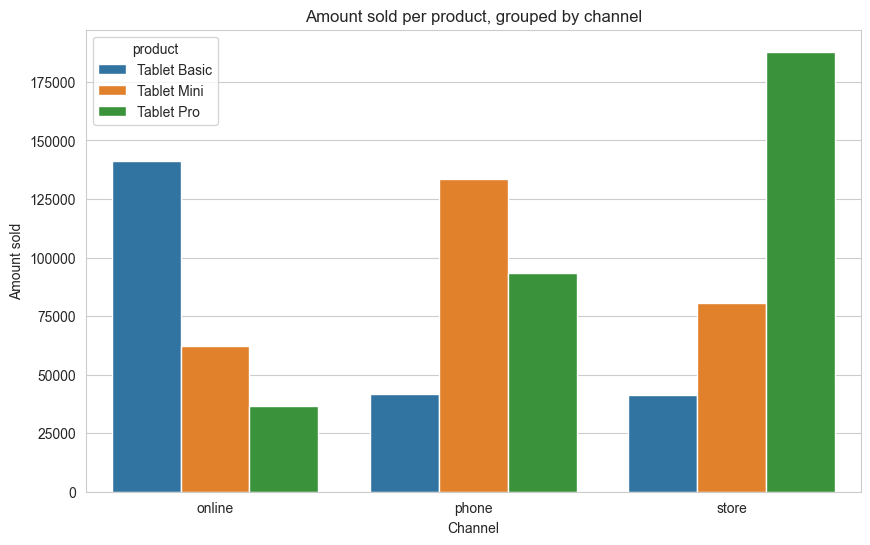

In [80]:
plt.figure(figsize=(10, 6))

sns.barplot(data=sales_per_product_by_channel, x='channel', y='amount', hue='product')

plt.title('Amount sold per product, grouped by channel')
plt.xlabel('Channel')
plt.ylabel('Amount sold')
plt.show()

### Wie oft wurden die Produkte in den einzelnen Regionen verkauft?

In [81]:
# Group by region, product and sum up amount
sales_per_product_by_region = df_sales.groupby(['region', 'product']).agg({'amount': 'sum'})
sales_per_product_by_region = sales_per_product_by_region.reset_index()
sales_per_product_by_region

,region,product,amount
0,A,Tablet Basic,37414
1,A,Tablet Mini,34399
2,A,Tablet Pro,36433
3,B,Tablet Basic,61842
4,B,Tablet Mini,81098
5,B,Tablet Pro,94030
6,C,Tablet Basic,83512
7,C,Tablet Mini,80366
8,C,Tablet Pro,61928
9,D,Tablet Basic,41472


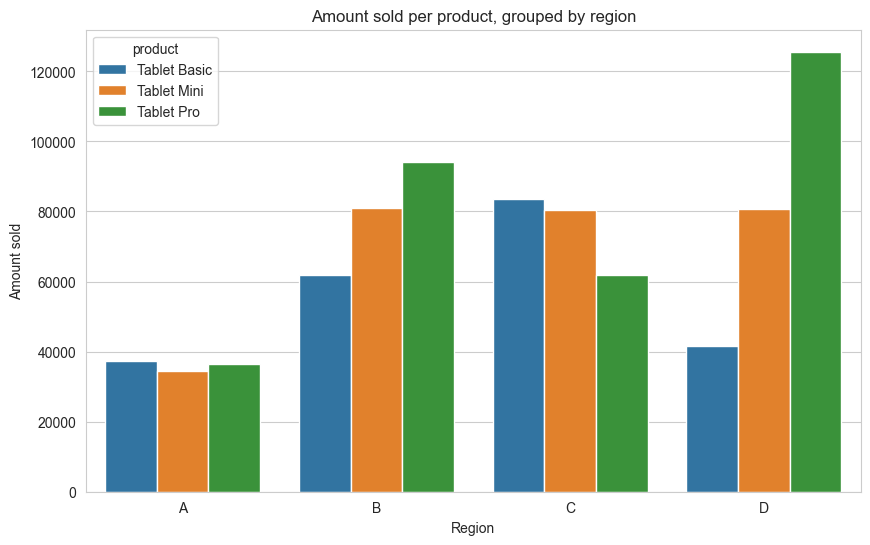

In [82]:
plt.figure(figsize=(10, 6))

sns.barplot(data=sales_per_product_by_region, x='region', y='amount', hue='product')

plt.title('Amount sold per product, grouped by region')
plt.xlabel('Region')
plt.ylabel('Amount sold')
plt.show()

In [83]:
# Profit per product, grouped by channel and region
profit_per_product_by_channel = df_sales.groupby(["region", 'channel', 'product']).agg({'profit_total': 'sum'})
profit_per_product_by_channel = profit_per_product_by_channel.reset_index()
profit_per_product_by_channel

,region,channel,product,profit_total
0,A,online,Tablet Basic,"6,498,481.40"
1,A,online,Tablet Mini,"5,109,423.48"
2,A,online,Tablet Pro,"1,728,208.22"
3,A,phone,Tablet Basic,"838,521.96"
4,A,phone,Tablet Mini,"4,950,294.18"
5,A,phone,Tablet Pro,"1,828,572.82"
6,A,store,Tablet Basic,"426,626.11"
7,A,store,Tablet Mini,"2,170,988.67"
8,A,store,Tablet Pro,"2,248,654.13"
9,B,online,Tablet Basic,"7,795,522.98"


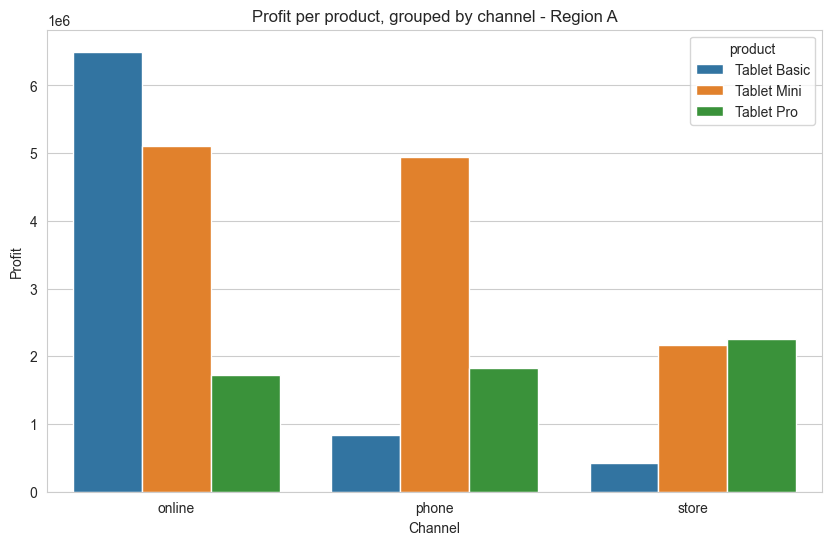

In [84]:
# Für Region A: Welche Produkte wurden in welchem Kanal mit welchem Gewinn verkauft?
profit_a = profit_per_product_by_channel[profit_per_product_by_channel['region'] == 'A']

# Plot
plt.figure(figsize=(10, 6))

sns.barplot(data=profit_a, x='channel', y='profit_total', hue='product')

plt.title('Profit per product, grouped by channel - Region A')
plt.xlabel('Channel')
plt.ylabel('Profit')
plt.show()


## Hypothese 7: Es wurden mehr Rabatte gewährt

In [85]:
# Durchschnittlicher Rabatt pro Monat
rabatt_pro_monat = df_sales.groupby(pd.Grouper(key='date', freq='M')).agg({'discount': 'mean'})
rabatt_pro_monat

,discount
date,
2021-11-30,0.02
2021-12-31,0.02
2022-01-31,0.01
2022-02-28,0.01
2022-03-31,0.01
2022-04-30,0.01
2022-05-31,0.01
2022-06-30,0.01
2022-07-31,0.01


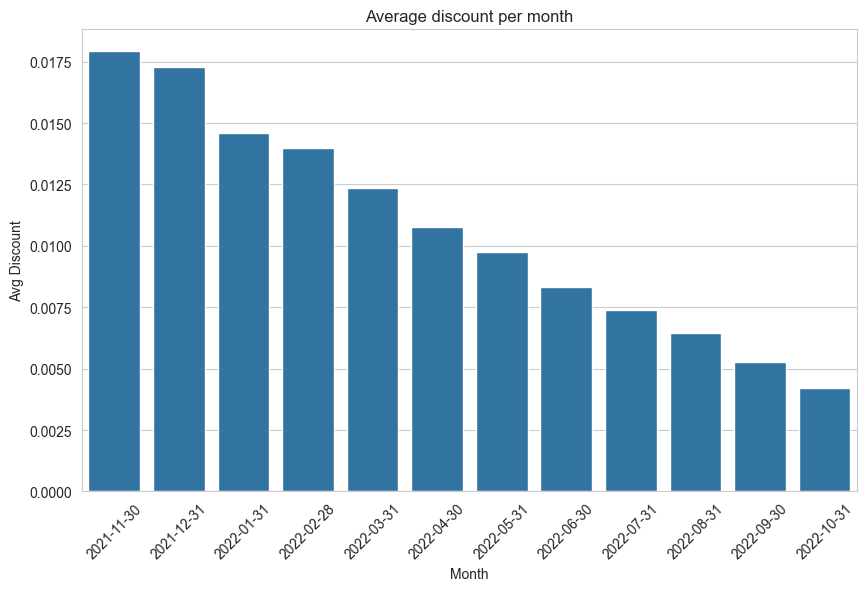

In [86]:
# Als barplot visualisieren
plt.figure(figsize=(10, 6))

sns.barplot(data=rabatt_pro_monat, x=rabatt_pro_monat.index, y='discount')
plt.title('Average discount per month')
plt.xlabel('Month')
plt.ylabel('Avg Discount')

#plt.ylim(0.90, 1.0)

plt.xticks(rotation=45)

plt.show()

- Nein, Rabatte haben sich sogar verringert

In [87]:
# Durchschnittliche Rabatte pro Produkt pro Monat
rabatt_pro_monat_pro_produkt = df_sales.groupby(['product', 'year', "month"]).agg({'discount': 'mean'})  
rabatt_pro_monat_pro_produkt

discount
product      year month          
Tablet Basic 2021 11         0.03
                  12         0.03
             2022 1          0.03
                  2          0.03
                  3          0.03
                  4          0.03
                  5          0.03
                  6          0.03
                  7          0.03
                  8          0.03
                  9          0.03
                  10         0.03
Tablet Mini  2021 11         0.01
                  12         0.01
             2022 1          0.01
                  2          0.01
                  3          0.01
                  4          0.01
                  5          0.01
                  6          0.01
                  7          0.01
                  8          0.01
                  9          0.01
                  10         0.01
Tablet Pro   2021 11         0.00
                  12         0.00
             2022 1          0.00
                  2          0.00
                  3          0.00
                  4          0.00
                  5          0.00
                  6          0.00
                  7          0.00
                  8          0.00
                  9          0.00
                  10         0.00

Text(0.5, 0, 'Month')

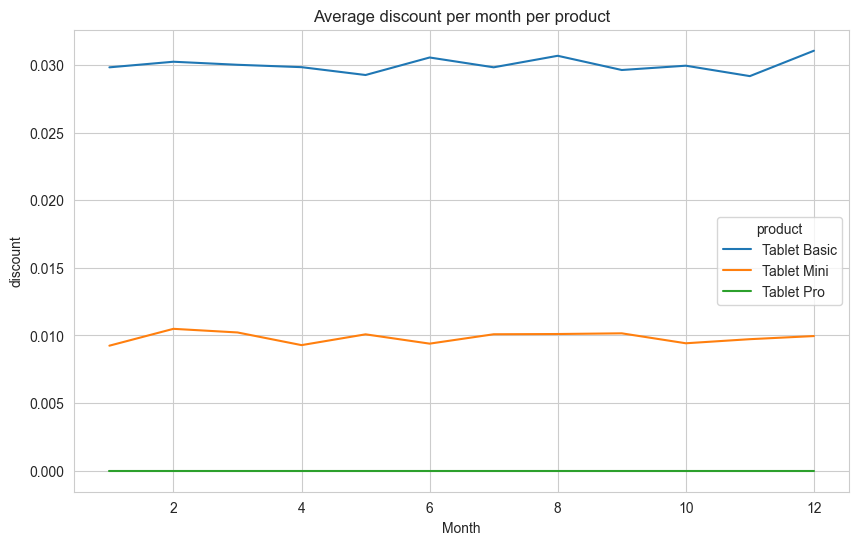

In [88]:
# Entfernen der Multi-Index-Spalten
rabatt_pro_monat_pro_produkt = rabatt_pro_monat_pro_produkt.reset_index()

plt.figure(figsize=(10, 6))

sns.lineplot(data=rabatt_pro_monat_pro_produkt, x='month', y='discount', hue='product')
plt.title('Average discount per month per product')
plt.xlabel('Month')

## Hypothese 8: Kundenzufriedenheit hat sich verändert

In [89]:
# Durschnittliches Customer Rating pro Monat für Tablet Basic
rating_basic = df_sales[df_sales['product'] == 'Tablet Basic'].groupby(pd.Grouper(key='date', freq='M')).agg({'customer_rating': 'mean'})

# Durschnittliches Customer Rating pro Monat für Tablet Mini
rating_mini = df_sales[df_sales['product'] == 'Tablet Mini'].groupby(pd.Grouper(key='date', freq='M')).agg({'customer_rating': 'mean'})

# Durschnittliches Customer Rating pro Monat für Tablet Pro
rating_pro = df_sales[df_sales['product'] == 'Tablet Pro'].groupby(pd.Grouper(key='date', freq='M')).agg({'customer_rating': 'mean'})

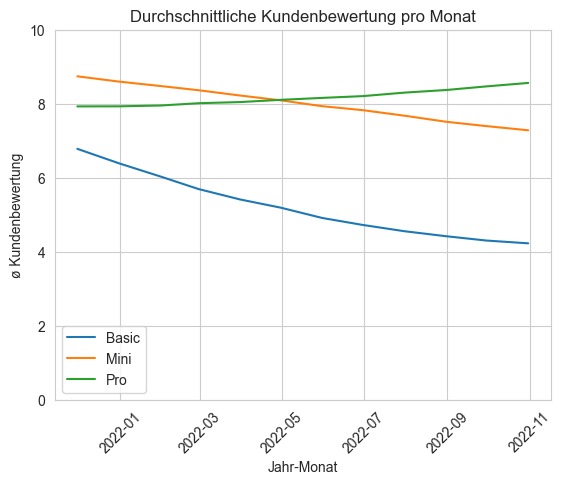

In [90]:
sns.lineplot(data=rating_basic, x=rating_basic.index, y='customer_rating', label='Basic')
sns.lineplot(data=rating_mini, x=rating_mini.index, y='customer_rating', label='Mini')
sns.lineplot(data=rating_pro, x=rating_pro.index, y='customer_rating', label='Pro')

plt.title('Durchschnittliche Kundenbewertung pro Monat')
plt.xlabel('Jahr-Monat')
plt.ylabel('ø Kundenbewertung')

plt.ylim(0, 10)
plt.xticks(rotation=45)

plt.show()

- Kundenzufriedenheit für Tablet Basic ist relativ stark gesunken
- Kundenzufriedenheit für Tablet Mini ist im Vergleich leichter gesunken
- Kundenzufriedenheit für Tablet Pro ist gestiegen

### (Versuch, Umsatz nach Customer Rating als Regression zu plotten)

<Axes: xlabel='customer_rating', ylabel='revenue'>

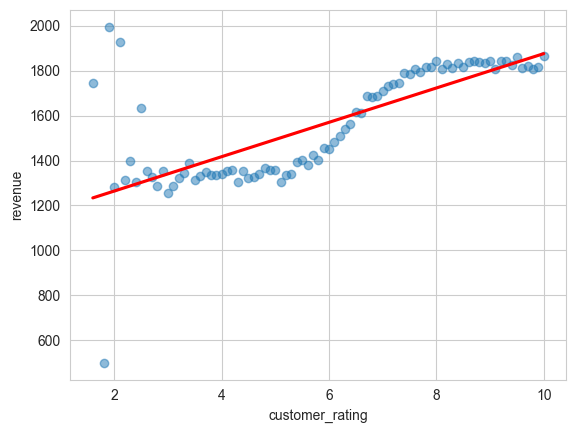

In [91]:
umsatz_by_customer_rating = df_sales.groupby('customer_rating').agg({'revenue': 'mean',
                                                                     "customer_rating": "mean"})

sns.regplot(x="customer_rating", y="revenue", data=umsatz_by_customer_rating, ci=True, 
            line_kws={"color": "red"}, scatter_kws={"alpha": 0.5})

In [92]:
# Lineare Regression für die Spalte "revenue" erstellen
model = smf.ols(formula='revenue ~ customer_rating', data=df_sales).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:              OLS              Adj. R-squared:     0.022       
Dependent Variable: revenue          AIC:                5715723.3582
Date:               2024-01-31 15:34 BIC:                5715744.8316
No. Observations:   340000           Log-Likelihood:     -2.8579e+06 
Df Model:           1                F-statistic:        7615.       
Df Residuals:       339998           Prob (F-statistic): 0.00        
R-squared:          0.022            Scale:              1.1706e+06  
---------------------------------------------------------------------
                   Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
---------------------------------------------------------------------
Intercept         941.3988   8.9911 104.7031 0.0000 923.7764 959.0212
customer_rating   101.5559   1.1638  87.2620 0.0000  99.2749 103.8369
---------------------------------------------------------------------
Omnibus:             99510.668      Durbin-Watson:         1.625     
Prob(Omnibus):       0.000          Jarque-Bera (JB):      331980.665
Skew:                1.482          Prob(JB):              0.000     
Kurtosis:            6.828          Condition No.:         38        
=====================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
"""

### Umsatz je Customer Rating für jedes Produkt

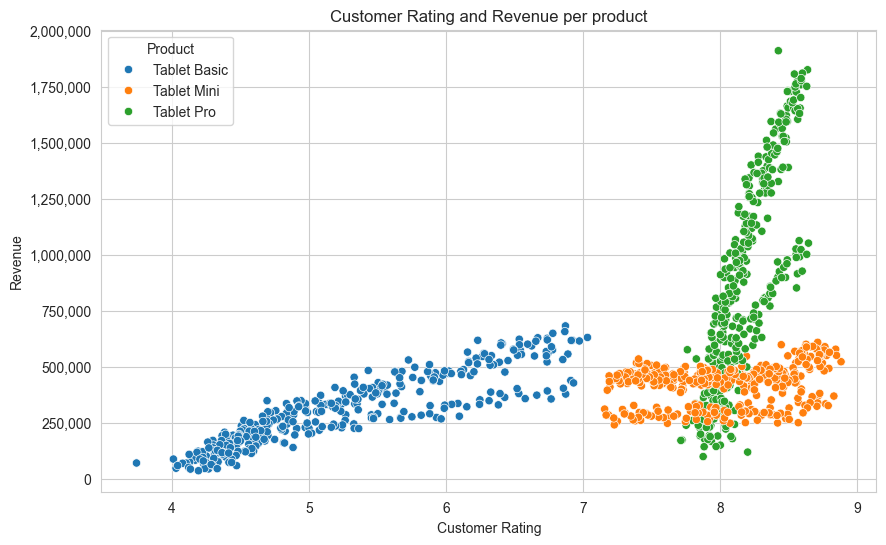

In [93]:
sales_by_rating = df_sales.groupby(["date", 'product']).agg({'customer_rating': 'mean',
                                                            'revenue': 'sum'})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=sales_by_rating, x='customer_rating', y='revenue', hue='product')
plt.title('Customer Rating and Revenue per product')
plt.xlabel('Customer Rating')
plt.ylabel('Revenue')
plt.legend(title="Product")

# y-Achse in Millionen formatieren
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.show()

In [94]:
correlation_sales_rating = sales_by_rating.corr()
correlation_sales_rating[['customer_rating']].loc[['revenue']]

,customer_rating
revenue,0.55


- Positive Korrelation: Es gibt eine positive Korrelation zwischen den Kundenbewertungen und den Verkaufszahlen. Dies deutet darauf hin, dass Produkte mit höheren Kundenbewertungen tendenziell höhere Verkaufszahlen aufweisen.

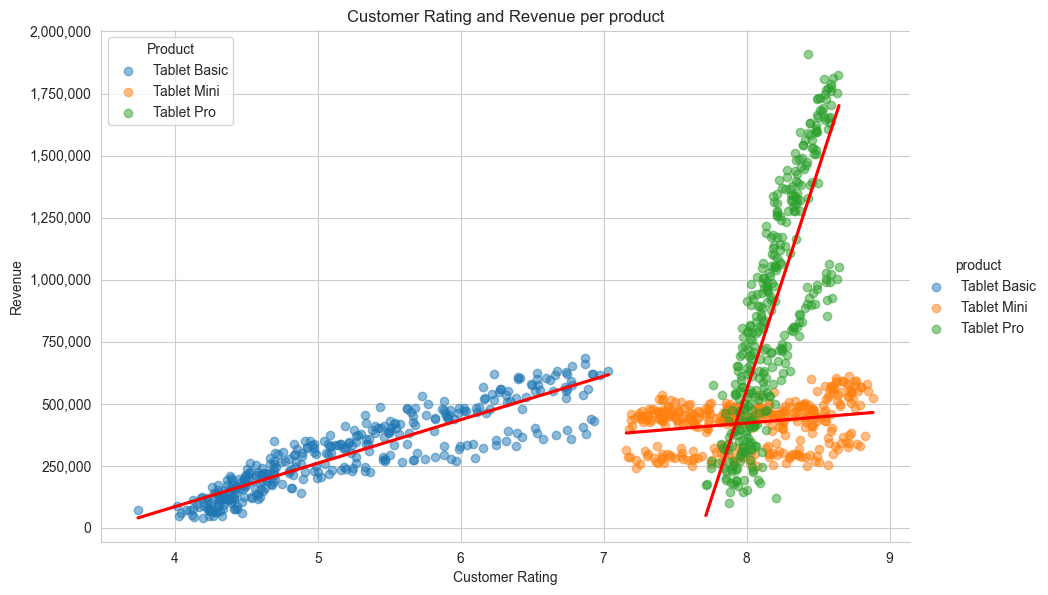

In [95]:
sales_by_rating = sales_by_rating.reset_index()
sns.lmplot(data=sales_by_rating, x="customer_rating", y="revenue", hue='product', ci=None, height=6, aspect=1.5, line_kws={"color": "red"}, scatter_kws={"alpha": 0.5})
plt.title('Customer Rating and Revenue per product')
plt.xlabel('Customer Rating')
plt.ylabel('Revenue')
plt.legend(title="Product")

# y-Achse in Millionen formatieren
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.show()

### Customer Rating nach Region

Text(0, 0.5, 'ø Kundenbewertung')

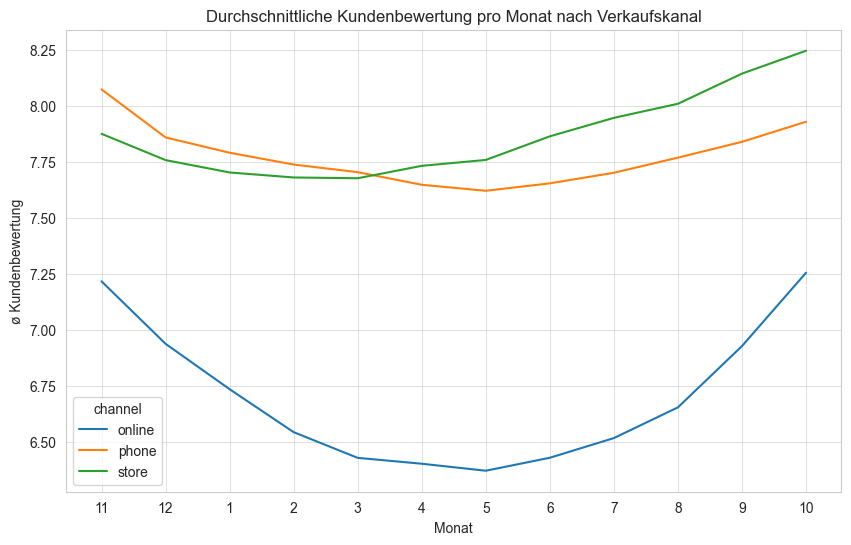

In [96]:
# Customer Rating nach region
rating_by_region = df_sales.groupby(['channel', 'year', 'month']).agg({'customer_rating': 'mean'})

# Entfernen der Multi-Index-Spalten
rating_by_region = rating_by_region.reset_index()

rating_by_region["month"] = rating_by_region["month"].astype(str)

plt.figure(figsize=(10, 6))

sns.lineplot(data=rating_by_region, x='month', y='customer_rating', hue='channel')

plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)

plt.title('Durchschnittliche Kundenbewertung pro Monat nach Verkaufskanal')
plt.xlabel('Monat')
plt.ylabel('ø Kundenbewertung')


In [97]:
# Kundenzufriedenheit je Produkt nach Channel
rating_by_product = df_sales.groupby(["year", "month", 'product', 'channel']).agg({'customer_rating': 'mean'})
rating_by_product = rating_by_product.reset_index()
rating_by_product

,year,month,product,channel,customer_rating
0,2021,11,Tablet Basic,online,6.79
1,2021,11,Tablet Basic,phone,6.75
2,2021,11,Tablet Basic,store,6.81
3,2021,11,Tablet Mini,online,8.77
4,2021,11,Tablet Mini,phone,8.74
...,...,...,...,...,...
103,2022,10,Tablet Mini,phone,7.30
104,2022,10,Tablet Mini,store,7.26
105,2022,10,Tablet Pro,online,8.60
106,2022,10,Tablet Pro,phone,8.57


In [98]:
# Ratings für Basic
rating_by_product_basic = rating_by_product[rating_by_product['product'] == 'Tablet Basic']
rating_by_product_basic.reset_index(inplace=True)
rating_by_product_basic["month"] = rating_by_product_basic["month"].astype(str)
rating_by_product_basic


/var/folders/11/mc30bzv91739f_0893v8dpb00000gn/T/ipykernel_13361/3893640345.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_by_product_basic["month"] = rating_by_product_basic["month"].astype(str)


,index,year,month,product,channel,customer_rating
0,0,2021,11,Tablet Basic,online,6.79
1,1,2021,11,Tablet Basic,phone,6.75
2,2,2021,11,Tablet Basic,store,6.81
3,9,2021,12,Tablet Basic,online,6.39
4,10,2021,12,Tablet Basic,phone,6.36
5,11,2021,12,Tablet Basic,store,6.44
6,18,2022,1,Tablet Basic,online,6.04
7,19,2022,1,Tablet Basic,phone,6.03
8,20,2022,1,Tablet Basic,store,6.03
9,27,2022,2,Tablet Basic,online,5.70


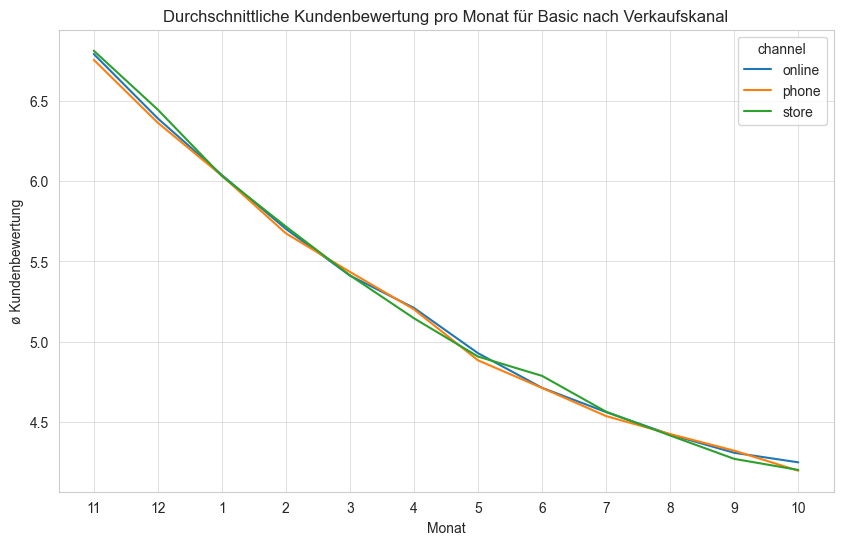

In [99]:
# Basic plotten, nach Channel
plt.figure(figsize=(10, 6))

sns.lineplot(data=rating_by_product_basic, x='month', y='customer_rating', hue='channel')

plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)

plt.title('Durchschnittliche Kundenbewertung pro Monat für Basic nach Verkaufskanal')
plt.xlabel('Monat')
plt.ylabel('ø Kundenbewertung')

plt.show()

/var/folders/11/mc30bzv91739f_0893v8dpb00000gn/T/ipykernel_13361/331888948.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_by_product_mini["month"] = rating_by_product_mini["month"].astype(str)


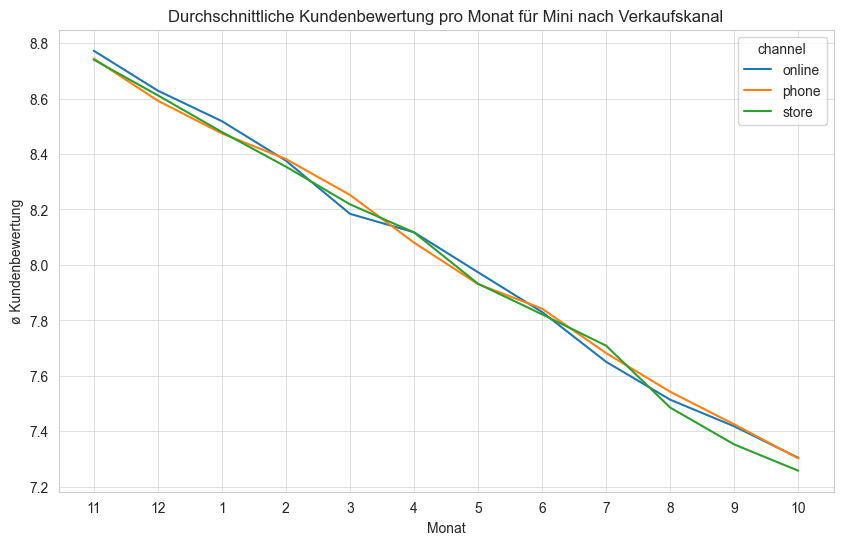

In [100]:
# Ratings für Mini
rating_by_product_mini = rating_by_product[rating_by_product['product'] == 'Tablet Mini']
rating_by_product_mini.reset_index(inplace=True)
rating_by_product_mini["month"] = rating_by_product_mini["month"].astype(str)
rating_by_product_mini

# Mini plotten, nach Channel
plt.figure(figsize=(10, 6))

sns.lineplot(data=rating_by_product_mini, x='month', y='customer_rating', hue='channel')

plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)

plt.title('Durchschnittliche Kundenbewertung pro Monat für Mini nach Verkaufskanal')
plt.xlabel('Monat')
plt.ylabel('ø Kundenbewertung')

plt.show()

## Hypothese 9: Downtime war ein Grund für die schlechte Entwicklung des Online-Stores

In [101]:
df_downtime

,year,region,downtime
0,2021,A,0.10
1,2022,A,0.15
2,2021,B,0.01
3,2022,B,0.15
4,2021,C,0.05
5,2022,C,0.04
6,2021,D,0.00
7,2022,D,0.01


In [102]:
# Alle Transaktionen im Kanal Online in einem Dataframe zusammenfassen
sales_online = df_sales[df_sales['channel'] == 'online']
sales_online

,date,product,discount,amount,tablet_basic,tablet_mini,tablet_pro,cost_basic,cost_mini,cost_pro,transaction_id,region,channel,customer_rating,year,month,week,price,cost,cost_total,revenue,profit_per_piece,profit_total
1,2021-11-01,Tablet Basic,0.00,3,1,0,0,170.00,0.00,0.00,1,D,online,8.40,2021,11,44,529,170.00,510.00,"1,587.00",359.00,"1,077.00"
3,2021-11-01,Tablet Basic,0.00,2,1,0,0,170.00,0.00,0.00,3,B,online,9.40,2021,11,44,529,170.00,340.00,"1,058.00",359.00,718.00
4,2021-11-01,Tablet Basic,0.00,2,1,0,0,150.00,0.00,0.00,4,C,online,9.10,2021,11,44,529,150.00,300.01,"1,058.00",379.00,757.99
7,2021-11-01,Tablet Basic,0.00,3,1,0,0,170.01,0.00,0.00,7,C,online,5.50,2021,11,44,529,170.01,510.02,"1,587.00",358.99,"1,076.98"
8,2021-11-01,Tablet Basic,0.00,1,1,0,0,150.01,0.00,0.00,8,C,online,6.20,2021,11,44,529,150.01,150.01,529.00,378.99,378.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339928,2022-10-31,Tablet Basic,0.00,4,1,0,0,449.94,0.00,0.00,339928,D,online,4.60,2022,10,44,499,449.94,"1,799.77","1,996.00",49.06,196.23
339932,2022-10-31,Tablet Pro,0.00,2,0,0,1,0.00,0.00,894.96,339932,C,online,10.00,2022,10,44,999,894.96,"1,789.92","1,998.00",104.04,208.08
339965,2022-10-31,Tablet Pro,0.00,3,0,0,1,0.00,0.00,854.98,339965,B,online,8.10,2022,10,44,999,854.98,"2,564.94","2,997.00",144.02,432.06
339966,2022-10-31,Tablet Pro,0.00,2,0,0,1,0.00,0.00,894.98,339966,B,online,7.90,2022,10,44,999,894.98,"1,789.96","1,998.00",104.02,208.04


### Fehlgeschlagene Analyse

In [103]:
# # Merge der Downtime-Daten in die Transaktionsdaten
sales_online = pd.merge(sales_online, df_downtime, how='left', on=['year', 'region'])

sales_online

,date,product,discount,amount,tablet_basic,tablet_mini,tablet_pro,cost_basic,cost_mini,cost_pro,transaction_id,region,channel,customer_rating,year,month,week,price,cost,cost_total,revenue,profit_per_piece,profit_total,downtime
0,2021-11-01,Tablet Basic,0.00,3,1,0,0,170.00,0.00,0.00,1,D,online,8.40,2021,11,44,529,170.00,510.00,"1,587.00",359.00,"1,077.00",0.00
1,2021-11-01,Tablet Basic,0.00,2,1,0,0,170.00,0.00,0.00,3,B,online,9.40,2021,11,44,529,170.00,340.00,"1,058.00",359.00,718.00,0.01
2,2021-11-01,Tablet Basic,0.00,2,1,0,0,150.00,0.00,0.00,4,C,online,9.10,2021,11,44,529,150.00,300.01,"1,058.00",379.00,757.99,0.05
3,2021-11-01,Tablet Basic,0.00,3,1,0,0,170.01,0.00,0.00,7,C,online,5.50,2021,11,44,529,170.01,510.02,"1,587.00",358.99,"1,076.98",0.05
4,2021-11-01,Tablet Basic,0.00,1,1,0,0,150.01,0.00,0.00,8,C,online,6.20,2021,11,44,529,150.01,150.01,529.00,378.99,378.99,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84994,2022-10-31,Tablet Basic,0.00,4,1,0,0,449.94,0.00,0.00,339928,D,online,4.60,2022,10,44,499,449.94,"1,799.77","1,996.00",49.06,196.23,0.01
84995,2022-10-31,Tablet Pro,0.00,2,0,0,1,0.00,0.00,894.96,339932,C,online,10.00,2022,10,44,999,894.96,"1,789.92","1,998.00",104.04,208.08,0.04
84996,2022-10-31,Tablet Pro,0.00,3,0,0,1,0.00,0.00,854.98,339965,B,online,8.10,2022,10,44,999,854.98,"2,564.94","2,997.00",144.02,432.06,0.15
84997,2022-10-31,Tablet Pro,0.00,2,0,0,1,0.00,0.00,894.98,339966,B,online,7.90,2022,10,44,999,894.98,"1,789.96","1,998.00",104.02,208.04,0.15


In [104]:
# Transaktionen nach regionen
sales_online_a = sales_online[sales_online['region'] == 'A']
sales_online_b = sales_online[sales_online['region'] == 'B']
sales_online_c = sales_online[sales_online['region'] == 'C']
sales_online_d = sales_online[sales_online['region'] == 'D']

# Umsätze monatlich aggregieren
monthly_sales_online_a = sales_online_a.groupby(pd.Grouper(key='date', freq='M')).agg({'transaction_id': 'count'})
monthly_sales_online_b = sales_online_b.groupby(pd.Grouper(key='date', freq='M')).agg({'transaction_id': 'count'})
monthly_sales_online_c = sales_online_c.groupby(pd.Grouper(key='date', freq='M')).agg({'transaction_id': 'count'})
monthly_sales_online_d = sales_online_d.groupby(pd.Grouper(key='date', freq='M')).agg({'transaction_id': 'count'})

In [105]:
def downtime_calculations (df, region):
    # Spalte date, year und month hinzufügen
    df = df.assign(date=df.index,
                   year=df.index.year,
                   month=df.index.month)
    
    # Spalte region hinzufügen
    df = df.assign(region=region)
    
    # Spalte downtime hinzufügen
    df = pd.merge(df, df_downtime, how='left', on=['year', 'region'])

    # Spalte possible_amount, delta und delta_rel hinzufügen
    df['possible_transactions'] = df['transaction_id'] / (1 - df['downtime'])
    df['delta'] = df['possible_transactions'] - df['transaction_id']
    df['delta_rel'] = df['delta'] / df['transaction_id']

    # Spalte transaction_id in "transaction_count" umbenennen
    df = df.rename(columns={'transaction_id': 'transaction_count'})
    
    return df

monthly_sales_online_a = downtime_calculations(monthly_sales_online_a, "A")
monthly_sales_online_b = downtime_calculations(monthly_sales_online_b, "B")
monthly_sales_online_c = downtime_calculations(monthly_sales_online_c, "C")
monthly_sales_online_d = downtime_calculations(monthly_sales_online_d, "D")
    

In [106]:
monthly_sales_online_a

,transaction_count,date,year,month,region,downtime,possible_transactions,delta,delta_rel
0,891,2021-11-30,2021,11,A,0.10,990.00,99.00,0.11
1,901,2021-12-31,2021,12,A,0.10,"1,001.11",100.11,0.11
2,827,2022-01-31,2022,1,A,0.15,972.94,145.94,0.18
3,750,2022-02-28,2022,2,A,0.15,882.35,132.35,0.18
4,809,2022-03-31,2022,3,A,0.15,951.76,142.76,0.18
5,706,2022-04-30,2022,4,A,0.15,830.59,124.59,0.18
6,755,2022-05-31,2022,5,A,0.15,888.24,133.24,0.18
7,641,2022-06-30,2022,6,A,0.15,754.12,113.12,0.18
8,618,2022-07-31,2022,7,A,0.15,727.06,109.06,0.18
9,594,2022-08-31,2022,8,A,0.15,698.82,104.82,0.18


In [107]:
monthly_sales_online_b

,transaction_count,date,year,month,region,downtime,possible_transactions,delta,delta_rel
0,2734,2021-11-30,2021,11,B,0.01,"2,761.62",27.62,0.01
1,2609,2021-12-31,2021,12,B,0.01,"2,635.35",26.35,0.01
2,2503,2022-01-31,2022,1,B,0.15,"2,944.71",441.71,0.18
3,2284,2022-02-28,2022,2,B,0.15,"2,687.06",403.06,0.18
4,2276,2022-03-31,2022,3,B,0.15,"2,677.65",401.65,0.18
5,2107,2022-04-30,2022,4,B,0.15,"2,478.82",371.82,0.18
6,2124,2022-05-31,2022,5,B,0.15,"2,498.82",374.82,0.18
7,1892,2022-06-30,2022,6,B,0.15,"2,225.88",333.88,0.18
8,1814,2022-07-31,2022,7,B,0.15,"2,134.12",320.12,0.18
9,1774,2022-08-31,2022,8,B,0.15,"2,087.06",313.06,0.18


In [108]:
monthly_sales_online_c

,transaction_count,date,year,month,region,downtime,possible_transactions,delta,delta_rel
0,3357,2021-11-30,2021,11,C,0.05,"3,533.68",176.68,0.05
1,3349,2021-12-31,2021,12,C,0.05,"3,525.26",176.26,0.05
2,3103,2022-01-31,2022,1,C,0.04,"3,232.29",129.29,0.04
3,2725,2022-02-28,2022,2,C,0.04,"2,838.54",113.54,0.04
4,2730,2022-03-31,2022,3,C,0.04,"2,843.75",113.75,0.04
5,2511,2022-04-30,2022,4,C,0.04,"2,615.62",104.62,0.04
6,2391,2022-05-31,2022,5,C,0.04,"2,490.62",99.62,0.04
7,2063,2022-06-30,2022,6,C,0.04,"2,148.96",85.96,0.04
8,2054,2022-07-31,2022,7,C,0.04,"2,139.58",85.58,0.04
9,1771,2022-08-31,2022,8,C,0.04,"1,844.79",73.79,0.04


In [109]:
monthly_sales_online_d

,transaction_count,date,year,month,region,downtime,possible_transactions,delta,delta_rel
0,2033,2021-11-30,2021,11,D,0.00,"2,033.00",0.00,0.00
1,2052,2021-12-31,2021,12,D,0.00,"2,052.00",0.00,0.00
2,2045,2022-01-31,2022,1,D,0.01,"2,065.66",20.66,0.01
3,1796,2022-02-28,2022,2,D,0.01,"1,814.14",18.14,0.01
4,1994,2022-03-31,2022,3,D,0.01,"2,014.14",20.14,0.01
5,1836,2022-04-30,2022,4,D,0.01,"1,854.55",18.55,0.01
6,1916,2022-05-31,2022,5,D,0.01,"1,935.35",19.35,0.01
7,1767,2022-06-30,2022,6,D,0.01,"1,784.85",17.85,0.01
8,1770,2022-07-31,2022,7,D,0.01,"1,787.88",17.88,0.01
9,1669,2022-08-31,2022,8,D,0.01,"1,685.86",16.86,0.01


<Axes: xlabel='date', ylabel='delta'>

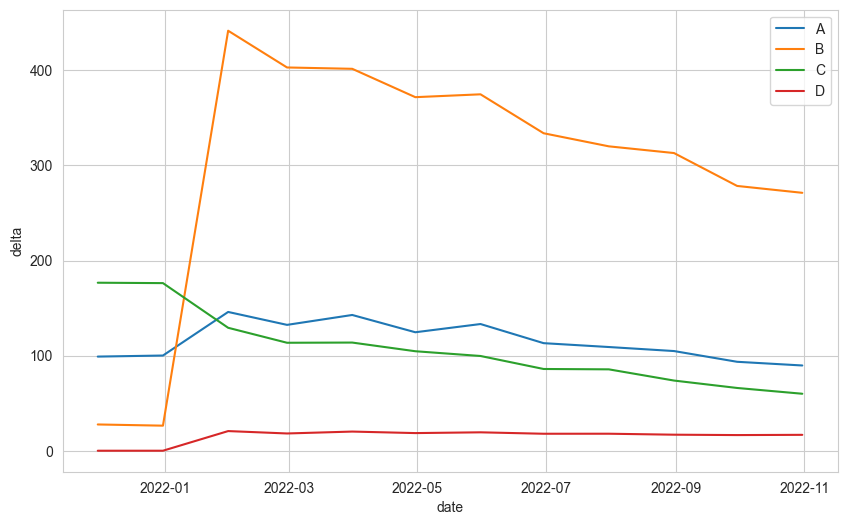

In [110]:
# Alle Deltas der vier Regionen plotten
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_sales_online_a, x='date', y='delta', label='A')
sns.lineplot(data=monthly_sales_online_b, x='date', y='delta', label='B')
sns.lineplot(data=monthly_sales_online_c, x='date', y='delta', label='C')
sns.lineplot(data=monthly_sales_online_d, x='date', y='delta', label='D')

### Prognose erstellen:
- Anhand der Monate November/Dezember 2021 eine Prognose für Januar 2022 machen und schauen, ob die Abweichung in der Prognose vom realen Wert durch die veränderte Downtime erklärt wird 

#### Beispielhaft für Region A:

In [111]:
# Anzahl Transaktionen pro Tag berechnen
daily_sales_online_a = sales_online_a.groupby(pd.Grouper(key='date', freq='D')).agg({'transaction_id': 'count'})
daily_sales_online_a

,transaction_id
date,
2021-11-01,23
2021-11-02,34
2021-11-03,32
2021-11-04,22
2021-11-05,43
...,...
2022-10-27,18
2022-10-28,27
2022-10-29,13


In [112]:
# Transaktionen pro Tag für die Monate November 2021 bis Januar 2022
daily_sales_online_a = daily_sales_online_a.loc['2021-11-01':'2022-01-31']

# In Dataframe umwandeln
daily_sales_online_a = daily_sales_online_a.reset_index()
daily_sales_online_a

,date,transaction_id
0,2021-11-01,23
1,2021-11-02,34
2,2021-11-03,32
3,2021-11-04,22
4,2021-11-05,43
...,...,...
87,2022-01-27,20
88,2022-01-28,23
89,2022-01-29,21
90,2022-01-30,27


In [113]:
# Exponentielle Glättung mit alpha=0.2
daily_sales_online_a['ewm'] = daily_sales_online_a['transaction_id'].ewm(alpha=0.2, adjust=False).mean()
daily_sales_online_a

,date,transaction_id,ewm
0,2021-11-01,23,23.00
1,2021-11-02,34,25.20
2,2021-11-03,32,26.56
3,2021-11-04,22,25.65
4,2021-11-05,43,29.12
...,...,...,...
87,2022-01-27,20,23.85
88,2022-01-28,23,23.68
89,2022-01-29,21,23.15
90,2022-01-30,27,23.92


In [114]:
# Forecast Error berechnen
daily_sales_online_a['forecast_error'] = ((daily_sales_online_a['transaction_id'] - daily_sales_online_a['ewm']) / daily_sales_online_a['transaction_id']) * 100

# Alle Zeilen anzeigen
pd.set_option('display.max_rows', None)
daily_sales_online_a

,date,transaction_id,ewm,forecast_error
0,2021-11-01,23,23.00,0.00
1,2021-11-02,34,25.20,25.88
2,2021-11-03,32,26.56,17.00
3,2021-11-04,22,25.65,-16.58
4,2021-11-05,43,29.12,32.28
5,2021-11-06,30,29.29,2.35
6,2021-11-07,33,30.04,8.98
7,2021-11-08,31,30.23,2.49
8,2021-11-09,30,30.18,-0.61
9,2021-11-10,26,29.35,-12.87


In [115]:
# Group by week
weekly_sales_online_a = daily_sales_online_a.groupby(pd.Grouper(key='date', freq='W')).agg({'transaction_id': 'sum', 'ewm': 'sum'})
weekly_sales_online_a

,transaction_id,ewm
date,,
2021-11-07,217,188.86
2021-11-14,198,202.73
2021-11-21,210,209.71
2021-11-28,207,205.42
2021-12-05,211,211.13
2021-12-12,205,202.81
2021-12-19,206,207.42
2021-12-26,187,198.57
2022-01-02,215,203.78


In [116]:
# Kalkuliere Prognosefehler als Prozent
weekly_sales_online_a['forecast_error'] = ((weekly_sales_online_a['transaction_id'] - weekly_sales_online_a['ewm']) / weekly_sales_online_a['transaction_id']) * 100
weekly_sales_online_a

,transaction_id,ewm,forecast_error
date,,,
2021-11-07,217,188.86,12.97
2021-11-14,198,202.73,-2.39
2021-11-21,210,209.71,0.14
2021-11-28,207,205.42,0.76
2021-12-05,211,211.13,-0.06
2021-12-12,205,202.81,1.07
2021-12-19,206,207.42,-0.69
2021-12-26,187,198.57,-6.19
2022-01-02,215,203.78,5.22
